# The Battle of Neighborhoods
___

## This is the notebook for the anaysis undertaken in the final assignment
### This notebook will be uploaded on GitHub

### Disclaimer:
This notebook was not completed in one run. It required several days to execute the code.  
Since it was not optimal to re-run the notebook all over again (especially the part where we extract the venues near the houses with foursquare API), I saved my results in csv files.  
I loaded these files again the next time I started the notebook to save time.  
This is why you will see that the code saves and loads files in some instances.

#### Load useful modules, set the working directory

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import requests

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
# this cell will be hidden

os.chdir(r"C:\Users\panos\Desktop\ML_Scripts\IBM-thesis")
os.getcwd()

'C:\\Users\\panos\\Desktop\\ML_Scripts\\IBM-thesis'

# Part 1: The dataset
___
In this section, we will load the dataset. This dataset contains house records in King County, USA. We will examine the features recorded, search for missing data or data that do not make sence and alter them. We will create new features if needed

## Reading the dataset

In [3]:
# reading the csv and showing the top 5 records
df = pd.read_csv('kc_house_data.csv')
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [94]:
c0 = df.columns
c0

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
df.shape

(21613, 21)

## Checking for missing data (nothing)

In [5]:
for x in df.columns.tolist(): print(x, sum(df[x].isna()), sum(df[x].isna())/df.shape[0], sep = '\t')

## Bedrooms and bathrooms

In [8]:
df[['bedrooms', 'bathrooms']].describe()

bedrooms     bathrooms
count  21613.000000  21613.000000
mean       3.370842      2.114757
std        0.930062      0.770163
min        0.000000      0.000000
25%        3.000000      1.750000
50%        3.000000      2.250000
75%        4.000000      2.500000
max       33.000000      8.000000

### Bedroom outlier
There is a record with 33 bedrooms. As seen in other works with this dataset  
it is probably a typo, as it was meant to be 3 bedrooms.
This is changed

In [10]:
df.loc[df['bedrooms'] == 33,'bedrooms'] = 3
df['bedrooms'].describe()

count    21613.000000
mean         3.369454
std          0.907964
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [11]:
# discard records with no bedrooms or no bathrooms
print('There are {} houses with no bedroom or bathroom'.format(
    df[((df['bedrooms']==0) | (df['bathrooms']==0))].shape[0]))

# discard records with no bedrooms or no bathrooms
df = df[((df['bedrooms']!=0) & (df['bathrooms']!=0))]
print('With them discarded, there are {} houses remaining'.format(df.shape[0]))

There are 16 houses with no bedroom or bathroom
With them discarded, there are 21597 houses remaining


In [12]:
plt.figure(figsize = (10,6))
plt.scatter(x = 'bedrooms', y = 'bathrooms', data = df, color = 'steelblue', marker = 'x')
plt.xlabel('bedrooms', fontsize = 14)
plt.ylabel('bathrooms', fontsize = 14)
plt.title('Comparison on bedrooms vs bathrooms in KC houses', fontsize = 18)
plt.show()

## Square living vs square foot
* sqft_living: Square footage of the apartment's interior living space
* sqft_lot: Square footage of the land space

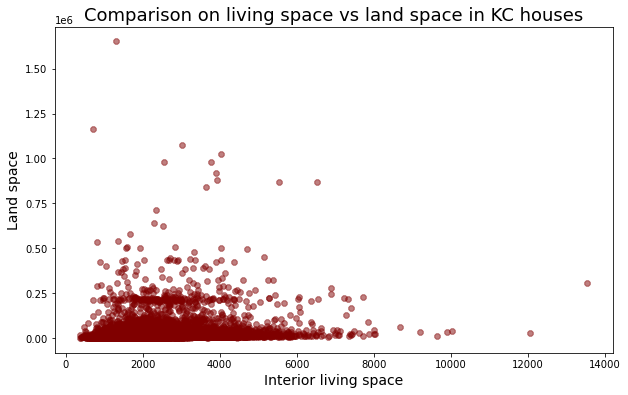

In [13]:
plt.figure(figsize = (10,6))
plt.scatter(x = 'sqft_living', y = 'sqft_lot', data = df, 
            color = 'maroon', marker = '8', alpha = 0.5)
plt.xlabel('Interior living space', fontsize = 14)
plt.ylabel('Land space', fontsize = 14)
plt.title('Comparison on living space vs land space in KC houses', fontsize = 18)
plt.show()

## Floors, waterfront, view, condition, grade

In [14]:
df_temp = df['floors'].value_counts().to_frame().reset_index()
df_temp.columns = ['amount_floors', 'count']
df_temp

amount_floors  count
0            1.0  10673
1            2.0   8235
2            1.5   1910
3            3.0    611
4            2.5    161
5            3.5      7

In [15]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(df_temp.shape[0]), df_temp['count'], color = 'orchid', width = 0.50)

ax.set_title('Amount of floors in KC houses', fontsize = 18)
ax.set_ylabel('Records', fontsize = 14)
ax.set_xlabel('Amount of floors', fontsize = 14)
ax.set_xticklabels([0] + df_temp['amount_floors'].apply(lambda x: str(x)).tolist())

[Text(0, 0, '0'),
 Text(0, 0, '1.0'),
 Text(0, 0, '2.0'),
 Text(0, 0, '1.5'),
 Text(0, 0, '3.0'),
 Text(0, 0, '2.5'),
 Text(0, 0, '3.5')]

In [16]:
df_temp = df['waterfront'].value_counts().to_frame().reset_index()
df_temp.columns = ['waterfront_view', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp

waterfront_view  count  count %
0                0  21434  99.2453
1                1    163   0.7547

In [17]:
df_temp = df['view'].value_counts().to_frame().reset_index()
df_temp.columns = ['view', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp.sort_values('view').set_index('view')

count  count %
view                
0     19475  90.1746
1       332   1.5373
2       961   4.4497
3       510   2.3614
4       319   1.4771

In [18]:
df_temp = df['condition'].value_counts().to_frame().reset_index()
df_temp.columns = ['condition', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp.sort_values('condition').set_index('condition')

count  count %
condition                
1             29   0.1343
2            170   0.7871
3          14020  64.9164
4           5677  26.2861
5           1701   7.8761

In [19]:
df_temp = df['grade'].value_counts().to_frame().reset_index()
df_temp.columns = ['grade', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp.sort_values('grade').set_index('grade')

count  count %
grade                
3          1   0.0046
4         27   0.1250
5        242   1.1205
6       2038   9.4365
7       8974  41.5521
8       6065  28.0826
9       2615  12.1082
10      1134   5.2507
11       399   1.8475
12        89   0.4121
13        13   0.0602

## Sqft above

In [20]:
plt.figure(figsize = (10,6))
plt.scatter(x = 'sqft_living', y = 'sqft_above', data = df, 
            color = 'steelblue', marker = '8', alpha = 0.9)
plt.xlabel('Interior living space', fontsize = 14)
plt.ylabel('Above', fontsize = 14)
plt.title('Living space above ground in KC houses', fontsize = 18)
plt.show()

### This validates that basement and above area is equal to the living area

In [21]:
(df['sqft_basement'] + df['sqft_above'] - df['sqft_living']).describe()

count    21597.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

## Year build and renovated
* If the value in yr_renovated is 0, then the house is not renovated
* We will create a new variable, indicating whether the house has been renovated or not

In [22]:
df.loc[:, ['yr_built', 'yr_renovated']].describe()

yr_built  yr_renovated
count  21597.000000  21597.000000
mean    1970.999676     84.464787
std       29.375234    401.821438
min     1900.000000      0.000000
25%     1951.000000      0.000000
50%     1975.000000      0.000000
75%     1997.000000      0.000000
max     2015.000000   2015.000000

In [23]:
df['is_renovated'] = 1*(df['yr_renovated']!=0)

df_temp = df['is_renovated'].value_counts().to_frame().reset_index()
df_temp.columns = ['is_renovated', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp.sort_values('is_renovated').set_index('is_renovated')

count  count %
is_renovated                
0             20683  95.7679
1               914   4.2321

# Part 2: Zipcode and Area code
___
* The zipcode can give us more information
* While we know that these houses are in King County, there is more info to that
* King County is consisted by areas, coded with a 3-digit number
* Since the dataset is huge (>21k records), we need to work in a smaller part of it
* We will find this information from a website, scrape it and use it to work in a specific area

## Create a zipcode dataframe, along with value counts

In [66]:
df_temp = df['zipcode'].value_counts().to_frame().reset_index()
df_temp.columns = ['zipcode', 'count']
df_temp['count %'] = (df_temp['count']*100 / df_temp['count'].sum()).round(4)
df_temp.head(6)

zipcode  count  count %
0    98103    602   2.7874
1    98038    589   2.7272
2    98115    583   2.6994
3    98052    574   2.6578
4    98117    553   2.5605
5    98042    547   2.5328

## With this loop, for every possible zipcode, we will get the respective area

In [165]:
no_area = []

for i in range(df_temp.shape[0]):
    zipp = df_temp.loc[i,'zipcode']
    url_zip = 'https://www.getzips.com/cgi-bin/ziplook.exe?What=1&Zip={}&Submit=Look+It+Up'.format(zipp)
    res = pd.read_html(url_zip)
    temp = res[2]
    temp.columns = temp.iloc[0,]
    temp = temp.iloc[1,].to_frame().transpose().reset_index()
    no_area.append(temp.loc[0,'AREA'])
    if (i+1) % 10 == 0: print(str(i+1), 'done!')

print(no_area)

10 done!
20 done!
30 done!
40 done!
50 done!
60 done!
70 done!
['206', '425', '206', '425', '206', '253', '425', '206', '253', '425', '206', '425', '425', '206', '425', '425', '425', '206', '425', '425', '253', '425', '206', '253', '206', '206', '206', '425', '425', '206', '425', '206', '206', '425', '425', '206', '206', '253', '253', '425', '206', '206', '425', '206', '206', '206', '253', '206', '206', '360', '206', '425', '253', '425', '425', '425', '206', '206', '425', '425', '206', '206', '425', '206', '206', '206', '360', '425', '206', '425']


In [178]:
df_temp['Area'] = no_area

print('Zipcodes per area code')
df_temp.Area.value_counts()

Zipcodes per area code


206    32
425    28
253     8
360     2
Name: Area, dtype: int64

In [176]:
# Save the zipcode-area data to a data frame
# so we don't have to repeat the process
# df_temp.to_csv('zipcode_area.csv', index=False)
print('saved')

saved


In [28]:
# Load the csv with zipcode and area codes
df_temp = pd.read_csv('zipcode_area.csv')
df_temp.head(10)

zipcode  count  count %  Area
0    98103    602   2.7854   206
1    98038    590   2.7298   425
2    98115    583   2.6975   206
3    98052    574   2.6558   425
4    98117    553   2.5586   206
5    98042    548   2.5355   253
6    98034    545   2.5216   425
7    98118    508   2.3504   206
8    98023    499   2.3088   253
9    98006    498   2.3042   425

## Join the area code to the original data

In [29]:
df_area = df.join(df_temp.loc[:,['zipcode', 'Area']].set_index('zipcode'), how = 'left', on = 'zipcode')
df_area.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0      5650     1.0           0     0  ...              0      1955   
1      7242     2.0           0     0  ...            400      1951   
2     10000     1.0           0     0  ...              0      1933   
3      5000     1.0           0     0  ...            910      1965   
4      8080     1.0           0     0  ...              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98178  47.5112 -122.257           1340        5650   
1          1991    98125  47.7210 -122.319           1690        7639   
2             0    98028  47.7379 -122.233           2720        8062   
3             0    98136  47.5208 -122.393           1360        5000   
4             0    98074  47.6168 -122.045           1800        7503   

   is_renovated  Area  
0             0   206  
1             1   206  
2             0   425  
3             0   206  
4             0   425  

[5 rows x 23 columns]

In [30]:
df_area.shape

(21597, 23)

In [31]:
# Save the data with area to a data frame
# so we don't have to repeat the process
# df_area.to_csv('df_area.csv', index=False)
# print('saved')

saved


In [32]:
print('Houses per area')
df_area['Area'].value_counts()

Houses per area


206    9497
425    9001
253    2766
360     333
Name: Area, dtype: int64

## Reload the data frame with area code
* We will work in area 253, as the number of houses is big enough

In [4]:
df_area = pd.read_csv('df_area.csv')
df_area.head(10)

id             date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000   221900.0         3       1.00         1180   
1  6414100192  20141209T000000   538000.0         3       2.25         2570   
2  5631500400  20150225T000000   180000.0         2       1.00          770   
3  2487200875  20141209T000000   604000.0         4       3.00         1960   
4  1954400510  20150218T000000   510000.0         3       2.00         1680   
5  7237550310  20140512T000000  1225000.0         4       4.50         5420   
6  1321400060  20140627T000000   257500.0         3       2.25         1715   
7  2008000270  20150115T000000   291850.0         3       1.50         1060   
8  2414600126  20150415T000000   229500.0         3       1.00         1780   
9  3793500160  20150312T000000   323000.0         3       2.50         1890   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0      5650     1.0           0     0  ...              0      1955   
1      7242     2.0           0     0  ...            400      1951   
2     10000     1.0           0     0  ...              0      1933   
3      5000     1.0           0     0  ...            910      1965   
4      8080     1.0           0     0  ...              0      1987   
5    101930     1.0           0     0  ...           1530      2001   
6      6819     2.0           0     0  ...              0      1995   
7      9711     1.0           0     0  ...              0      1963   
8      7470     1.0           0     0  ...            730      1960   
9      6560     2.0           0     0  ...              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98178  47.5112 -122.257           1340        5650   
1          1991    98125  47.7210 -122.319           1690        7639   
2             0    98028  47.7379 -122.233           2720        8062   
3             0    98136  47.5208 -122.393           1360        5000   
4             0    98074  47.6168 -122.045           1800        7503   
5             0    98053  47.6561 -122.005           4760      101930   
6             0    98003  47.3097 -122.327           2238        6819   
7             0    98198  47.4095 -122.315           1650        9711   
8             0    98146  47.5123 -122.337           1780        8113   
9             0    98038  47.3684 -122.031           2390        7570   

   is_renovated  Area  
0             0   206  
1             1   206  
2             0   425  
3             0   206  
4             0   425  
5             0   425  
6             0   253  
7             0   206  
8             0   206  
9             0   425  

[10 rows x 23 columns]

In [6]:
# Note that 'Area' is considered integer if loaded by csv, not string
df253 = df_area[df_area['Area'] == 253].reset_index().iloc[:,1:]
df253.shape

(2766, 23)

In [7]:
df253['price'].describe()

count    2.766000e+03
mean     2.962305e+05
std      1.027734e+05
min      8.650000e+04
25%      2.330000e+05
50%      2.759500e+05
75%      3.350000e+05
max      1.275000e+06
Name: price, dtype: float64

In [46]:
# !conda install -c conda-forge folium=0.5.0 --yes
import folium

kc_map0 = folium.Map(location = [47.3084, -122.234], zoom_start = 11,width = 1080, height = 585)

for lat, lng, id0, price in zip(df253['lat'], df253['long'], df253['id'], df253['price']):
    label = '{}, {}'.format('ID'+str(id0), price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup = label,
        color = '#1a53ff',
        fill = True,
        fill_color = '#80d4ff',
        fill_opacity = 0.8,
        parse_html = False).add_to(kc_map0)  
    
kc_map0

# Part 3: Acquire data from Foursquare, based on latitude and longitude
___
In this section, we will use the longitude and latitide data to search for venues near the houses. This data will be useful as they might affect the house price

## Search for venues

#### The following cell contains Foursquare credentials. After I run the code, I deleted them.

In [5]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Test it on a record

In [6]:
LIMIT = 30
radius = 500

lat = df253.loc[0,'lat']
lng = df253.loc[0,'long']

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

print(lat, lng)

47.3097 -122.327


In [41]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f31ff8f6c66494826b1cd64'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Federal Way',
  'headerFullLocation': 'Federal Way',
  'headerLocationGranularity': 'city',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 47.3142000045, 'lng': -122.32037556191375},
   'sw': {'lat': 47.3051999955, 'lng': -122.33362443808625}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5186ed75498eb86cd6101c82',
       'name': 'Heineken Palace',
       'location': {'lat': 47.306926,
        'lng': -122.323293,
        'labeledLatLngs': [{'label': 'display',
          'lat': 47.306926,
          'lng': -122.323293}],
    

In [9]:
results[0]['venue']['name']

'Heineken Palace'

## Retrieve venues for the dataset
* Define a function to fetch the data for all records
* Define a function to extract the venue category

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    i=0
    for name, lat, lng in zip(names, latitudes, longitudes):
        i = i+1
        if i % 50 == 0: print(i)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ID', 
                  'ID Latitude', 
                  'ID Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### The first portion 1-1100

In [16]:
df_venues = getNearbyVenues(names = df253.loc[0:1100, 'id'],
                                   latitudes = df253.loc[0:1100,'lat'],
                                   longitudes = df253.loc[0:1100,'long']
                                  )

df_venues.head()

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100


ID  ID Latitude  ID Longitude                   Venue  \
0  1321400060      47.3097      -122.327         Heineken Palace   
1  1321400060      47.3097      -122.327        Geo-Trek Stop #4   
2    16000397      47.3089      -122.210  Athens Pizza and Pasta   
3    16000397      47.3089      -122.210       Peckenpaugh Drugs   
4    16000397      47.3089      -122.210      Main Street Market   

   Venue Latitude  Venue Longitude      Venue Category  
0       47.306926      -122.323293          Campground  
1       47.307914      -122.321155               Trail  
2       47.308102      -122.216465  Italian Restaurant  
3       47.308449      -122.214012            Pharmacy  
4       47.308523      -122.214112       Grocery Store

In [17]:
df_venues.shape

(3432, 7)

In [21]:
# df_venues.to_csv('output_foursquare/df_venues_0_1100.csv', index=False)
# print('saved')

saved


### The second 1101-1600

In [25]:
df_venues = getNearbyVenues(names = df253.loc[1100:1600, 'id'],
                                   latitudes = df253.loc[1100:1600,'lat'],
                                   longitudes = df253.loc[1100:1600,'long']
                                  )

df_venues.head()

50
100
150
200
250
300
350
400
450
500


ID  ID Latitude  ID Longitude                       Venue  \
0  2991000220      47.3287      -122.167                    The view   
1  8091410530      47.3511      -122.169                 Holiday Inn   
2  8651410740      47.3677      -122.078         Locksmith Covington   
3  8651410740      47.3677      -122.078            The Bomb Shelter   
4  8651410740      47.3677      -122.078  Lennar at Cedar Creek Park   

   Venue Latitude  Venue Longitude  Venue Category  
0       47.326401      -122.161402  Scenic Lookout  
1       47.350471      -122.173783           Hotel  
2       47.369705      -122.079224       Locksmith  
3       47.368820      -122.074638     Beer Garden  
4       47.366199      -122.073204    Home Service

In [28]:
df_venues.shape

(1600, 7)

In [29]:
# df_venues.to_csv('output_foursquare/df_venues_1100_1600.csv', index=False)
# print('saved')

saved


### The 1601 to 2200

In [35]:
df_venues = getNearbyVenues(names = df253.loc[1600:2200, 'id'],
                                   latitudes = df253.loc[1600:2200,'lat'],
                                   longitudes = df253.loc[1600:2200,'long']
                                  )

df_venues.head()

50
100
150
200
250
300
350
400
450
500
550
600


ID  ID Latitude  ID Longitude       Venue  Venue Latitude  \
0  1858600012      47.3644        -122.2      Target       47.366270   
1  1858600012      47.3644        -122.2   Starbucks       47.366011   
2  1858600012      47.3644        -122.2    GameStop       47.366934   
3  1858600012      47.3644        -122.2       Petco       47.366841   
4  1858600012      47.3644        -122.2  Party City       47.366627   

   Venue Longitude      Venue Category  
0      -122.203033       Big Box Store  
1      -122.203432         Coffee Shop  
2      -122.204844    Video Game Store  
3      -122.204813           Pet Store  
4      -122.204561  Miscellaneous Shop

In [37]:
# df_venues.to_csv('output_foursquare/df_venues_1600_2200.csv', index=False)
# print('saved')

saved


In [36]:
df_venues.shape

(2107, 7)

### The last

In [43]:
df_venues = getNearbyVenues(names = df253.loc[2200:2600, 'id'],
                                   latitudes = df253.loc[2200:2600,'lat'],
                                   longitudes = df253.loc[2200:2600,'long']
                                  )

df_venues.head()

50
100
150
200
250
300
350
400


ID  ID Latitude  ID Longitude  \
0  8651402750      47.3615      -122.087   
1  8651402750      47.3615      -122.087   
2  8651402750      47.3615      -122.087   
3  8651402750      47.3615      -122.087   
4  8651402750      47.3615      -122.087   

                                     Venue  Venue Latitude  Venue Longitude  \
0  Lund Construction and Handyman Services       47.361808      -122.086283   
1          Ahola Concrete Construction LLC       47.364074      -122.088683   
2               appliance repair covington       47.363689      -122.083145   
3         JUICE WORKS INTL RESEARCH CENTER       47.358421      -122.084477   
4             garage door repair covington       47.358364      -122.082741   

      Venue Category  
0       Home Service  
1       Home Service  
2       Home Service  
3     Medical Center  
4  Other Repair Shop

In [44]:
df_venues.shape

(1348, 7)

In [45]:
# df_venues.to_csv('output_foursquare/df_venues_2200_2600.csv', index=False)
# print('saved')

saved


In [47]:
df_venues = getNearbyVenues(names = df253.loc[2600:, 'id'],
                                   latitudes = df253.loc[2600:,'lat'],
                                   longitudes = df253.loc[2600:,'long']
                                  )

df_venues.head()

50
100
150


ID  ID Latitude  ID Longitude                         Venue  \
0  3356402705      47.2874      -122.257         Sharper Lawn & Garden   
1  3356402705      47.2874      -122.257        Master Garden Products   
2  3356402705      47.2874      -122.257              sisters espresso   
3  1760650280      47.3612      -122.081  garage door repair covington   
4  1760650280      47.3612      -122.081             Evil Twin Brewery   

   Venue Latitude  Venue Longitude              Venue Category  
0       47.290287      -122.256258  Construction & Landscaping  
1       47.290368      -122.255500                 Flower Shop  
2       47.283736      -122.259319                        Café  
3       47.358364      -122.082741           Other Repair Shop  
4       47.361812      -122.075740                     Brewery

In [48]:
# df_venues.to_csv('output_foursquare/df_venues_2600.csv', index=False)
# print('saved')

saved


In [49]:
df_venues.shape

(508, 7)

## Read the venues data

In [8]:
df_venues1 = pd.read_csv('output_foursquare/df_venues_0_1100.csv')
df_venues2 = pd.read_csv('output_foursquare/df_venues_1100_1600.csv')
df_venues3 = pd.read_csv('output_foursquare/df_venues_1600_2200.csv')
df_venues4 = pd.read_csv('output_foursquare/df_venues_2200_2600.csv')
df_venues5 = pd.read_csv('output_foursquare/df_venues_2600.csv')

In [9]:
print(df_venues1.shape)
print(df_venues2.shape)
print(df_venues3.shape)
print(df_venues4.shape)
print(df_venues5.shape)

(3432, 7)
(1600, 7)
(2107, 7)
(1348, 7)
(508, 7)


In [13]:
df_venues = pd.concat([df_venues1, df_venues2, df_venues3, df_venues4, df_venues5], ignore_index = True)

In [14]:
df_venues.shape

(8995, 7)

In [15]:
# df_venues.to_csv('output_foursquare/df_venues_complete.csv', index=False)
# print('saved')

saved


# Part 4: Grouping the venue categories
___
We will group the venue categories into broader groups (e.g. places to eat, accomodation, shops).
This will reduce the amount of features for modeling

## Reload the complete venues dataset

In [8]:
df_venues = pd.read_csv('output_foursquare/df_venues_complete.csv')
df_venues.head(20)

ID  ID Latitude  ID Longitude  \
0   1321400060      47.3097      -122.327   
1   1321400060      47.3097      -122.327   
2     16000397      47.3089      -122.210   
3     16000397      47.3089      -122.210   
4     16000397      47.3089      -122.210   
5     16000397      47.3089      -122.210   
6     16000397      47.3089      -122.210   
7     16000397      47.3089      -122.210   
8   7983200060      47.3343      -122.306   
9   7983200060      47.3343      -122.306   
10  7137970340      47.3266      -122.169   
11  7137970340      47.3266      -122.169   
12  7137970340      47.3266      -122.169   
13  7137970340      47.3266      -122.169   
14  7137970340      47.3266      -122.169   
15  8091400200      47.3533      -122.166   
16  8091400200      47.3533      -122.166   
17  8091400200      47.3533      -122.166   
18  8091400200      47.3533      -122.166   
19  8091400200      47.3533      -122.166   

                                        Venue  Venue Latitude  \
0                             Heineken Palace       47.306926   
1                            Geo-Trek Stop #4       47.307914   
2                      Athens Pizza and Pasta       47.308102   
3                           Peckenpaugh Drugs       47.308449   
4                          Main Street Market       47.308523   
5                              Mom's Teriyaki       47.308523   
6   Auburn Valley Humane Society Thrift Store       47.308523   
7             Cedar River Smokehouse Barbecue       47.305450   
8                              Sacajawea Park       47.335147   
9                          Redwoods Salon Spa       47.337281   
10                                     Subway       47.322883   
11                                     SUBWAY       47.322960   
12                 D'Lara Mediterranean Grill       47.323208   
13                         Ringo Wok Teriyaki       47.323208   
14                            Herfy's Burgers       47.323414   
15                                  Starbucks       47.356644   
16                                  Starbucks       47.357665   
17                                    Safeway       47.356968   
18                                 Chase Bank       47.357476   
19                                  Pizza Hut       47.357352   

    Venue Longitude          Venue Category  
0       -122.323293              Campground  
1       -122.321155                   Trail  
2       -122.216465      Italian Restaurant  
3       -122.214012                Pharmacy  
4       -122.214112           Grocery Store  
5       -122.214112     Japanese Restaurant  
6       -122.214112  Thrift / Vintage Store  
7       -122.207108                    Food  
8       -122.306804                    Park  
9       -122.310967                     Spa  
10      -122.172611          Sandwich Place  
11      -122.172824          Sandwich Place  
12      -122.172264        Greek Restaurant  
13      -122.172264     Japanese Restaurant  
14      -122.173325            Burger Joint  
15      -122.166827             Coffee Shop  
16      -122.165887             Coffee Shop  
17      -122.166472           Grocery Store  
18      -122.164910                    Bank  
19      -122.168000             Pizza Place

In [6]:
df_venues.groupby('ID').count().sort_values('Venue Category', ascending = False).iloc[:,0]

ID
6138000095    30
7875200005    30
2722059183    30
5057100080    30
5057100090    30
              ..
6181500120     1
6187100360     1
1796370150     1
1796361140     1
6600780130     1
Name: ID Latitude, Length: 2371, dtype: int64

In [7]:
categories = df_venues['Venue Category'].unique().tolist()
print(len(categories))

254


In [192]:
categories

['Campground',
 'Trail',
 'Italian Restaurant',
 'Pharmacy',
 'Grocery Store',
 'Japanese Restaurant',
 'Thrift / Vintage Store',
 'Food',
 'Park',
 'Spa',
 'Sandwich Place',
 'Greek Restaurant',
 'Burger Joint',
 'Coffee Shop',
 'Bank',
 'Pizza Place',
 'Hotel',
 'Baseball Field',
 'Flower Shop',
 'Farmers Market',
 'Golf Course',
 'Arts & Entertainment',
 'Thai Restaurant',
 'Insurance Office',
 'Casino',
 'Dance Studio',
 'Construction & Landscaping',
 'Brewery',
 'Locksmith',
 'Home Service',
 'Other Repair Shop',
 'Carpet Store',
 'Restaurant',
 'Sushi Restaurant',
 'Food Service',
 'Juice Bar',
 'Cosmetics Shop',
 'Department Store',
 'Taco Place',
 'ATM',
 'Chinese Restaurant',
 'Mobile Phone Shop',
 'Convenience Store',
 'Gas Station',
 'Mexican Restaurant',
 'Gastropub',
 'Asian Restaurant',
 'Fast Food Restaurant',
 'Seafood Restaurant',
 'Clothing Store',
 'Business Service',
 'Bookstore',
 'Music Venue',
 'Gym / Fitness Center',
 'Pet Service',
 'Playground',
 'Lawyer',
 'F

## Group venue categories
* There are many venue categories that can be grouped in order to reduce variables (e.g. places where one can eat food such as the restaurants)
* We will inspect the venue categories and group them
* We will create a data frame, where each venue category will be given a code that identifies the broader group (e.g. places to eat, transportation, accomodation, attractions, shops etc.)
* We will search for key words in order to group venues

In [215]:
# This dictionary will be used to create our data frame: venue category and group code
venue_dict = {'venue categories': categories, 'groups': np.repeat(0, len(categories)).tolist()}

# Define the data frame, then discard the dictionary
df_vengroups = pd.DataFrame(venue_dict)

In [216]:
# venue categories that recieved a group, initially no category has a group
ven_grouped = []

# venues that have not recieved a group yet, initially all categories are ungrouped
ven_ungrouped = categories[:]

# grouped vs ungrouped
print('\n', len(ven_grouped), len(ven_ungrouped), len(ven_ungrouped + ven_grouped))


 0 254 254


In [217]:
# This function will update our group data frame, as well as the grouped - ungrouped lists

def ven_group_update(venue_cat, df, code, ven_grouped, ven_ungrouped):
    # How many vanue categories does this group contain?
    print('Venue categories in this group: {}\nPercentage of them: {}%\n'.format(
        len(venue_cat), 
        round(100*len(venue_cat)/len(categories),2)))

    print(venue_cat, '\n')

    # Add the code to the venue categories data frame
    for i in range(df.shape[0]):
        if df.iloc[i,0] in venue_cat:
            df.iloc[i,1] = code
        

    # Append the newly grouped categories to the grouped list
    ven_grouped = ven_grouped + venue_cat
    print('We have grouped {} venue categories'.format(len(set(ven_grouped))))
    print('We have {} venue categories to be grouped'.format(len(set(categories) - set(ven_grouped))))

    # Remove the newly grouped categories from the ungrouped list
    for x in venue_cat: ven_ungrouped.remove(x)
    print('\n', len(ven_grouped), len(ven_ungrouped), len(ven_ungrouped + ven_grouped))
    
    return df, ven_grouped, ven_ungrouped

#### Group 1: Places to eat

In [218]:
# Define the keywords in order to search for the right venue categories
keywords = ['restaurant', 'pizza', 'burger', 'sandwich', 'bbq', 'breakfast', 'barbeque', 'burrito', 'deli', 'bodega',
           'food', 'taco', 'soup', 'chicken', 'wings', 'hot dog', 'fish', 'chips', 'steak', 'diner', 'noodle']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if ( ('shop' not in cat.lower()) &
                                          ('store' not in cat.lower()) &
                                          any(word in cat.lower() for word in keywords) )]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 11, ven_grouped, ven_ungrouped)

Venue categories in this group: 42
Percentage of them: 16.54%

['Italian Restaurant', 'Japanese Restaurant', 'Food', 'Sandwich Place', 'Greek Restaurant', 'Burger Joint', 'Pizza Place', 'Thai Restaurant', 'Restaurant', 'Sushi Restaurant', 'Food Service', 'Taco Place', 'Chinese Restaurant', 'Mexican Restaurant', 'Asian Restaurant', 'Fast Food Restaurant', 'Seafood Restaurant', 'Soup Place', 'Korean Restaurant', 'Vietnamese Restaurant', 'Mediterranean Restaurant', 'Indian Restaurant', 'American Restaurant', 'Noodle House', 'Wings Joint', 'Hot Dog Joint', 'Diner', 'Deli / Bodega', 'German Restaurant', 'Food Truck', 'Food Court', 'Latin American Restaurant', 'Breakfast Spot', 'Burrito Place', 'Japanese Curry Restaurant', 'Southern / Soul Food Restaurant', 'Steakhouse', 'BBQ Joint', 'Ramen Restaurant', 'Pakistani Restaurant', 'Fried Chicken Joint', 'Filipino Restaurant'] 

We have grouped 42 venue categories
We have 212 venue categories to be grouped

 42 212 254


In [219]:
# how many venues are considered as places to eat?
df_venues['Venue Category'].apply(lambda x: any([word in x.lower() for word in keywords])).sum()

1973

#### Group 2: Places to drink

In [220]:
# Define the keywords in order to search for the right venue categories
keywords = ['bar', 'wine', 'beer', 'pub', 'coffee', 'café', 'cafe']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if ( ('shop' not in cat.lower()) &
                                          ('store' not in cat.lower()) &
                                          any(word in cat.lower() for word in keywords) )]
venue_cat.append('Coffee Shop')


# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 12, ven_grouped, ven_ungrouped)

Venue categories in this group: 15
Percentage of them: 5.91%

['Juice Bar', 'Gastropub', 'Bar', 'Café', 'Cocktail Bar', 'Dive Bar', 'Beer Garden', 'Sake Bar', 'Sports Bar', 'Karaoke Bar', 'Pub', 'Beer Bar', 'Gaming Cafe', 'Wine Bar', 'Coffee Shop'] 

We have grouped 57 venue categories
We have 197 venue categories to be grouped

 57 197 254


#### Group 3: Venues related to sports and athletics

In [221]:
# Define the keywords in order to search for the right venue categories
keywords = ['soccer', 'basketball', 'baseball', 'rugby', 'hockey', 'sport', 'gym', 'fit', 'yoga', 'pilates',
              'martial', 'race','athle', 'field', 'court', 'stadium', 'golf', 'dive', 'swim', 'pool', 'weight loss',
             'skate', 'ski', 'run']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]
venue_cat.append('Outdoors & Recreation')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 21, ven_grouped, ven_ungrouped)

Venue categories in this group: 33
Percentage of them: 12.99%

['Baseball Field', 'Golf Course', 'Gym / Fitness Center', 'Soccer Field', 'Gym', 'Basketball Court', 'Track Stadium', 'Football Stadium', 'Gym Pool', 'Dog Run', 'Sporting Goods Shop', 'Pool', 'Yoga Studio', 'Skate Park', 'Stadium', 'Martial Arts School', 'Baseball Stadium', 'Dive Spot', 'Pilates Studio', 'Soccer Stadium', 'Sports Club', 'Mini Golf', 'Pool Hall', 'Racetrack', 'Tennis Court', 'Athletics & Sports', 'Hockey Arena', 'Disc Golf', 'Ski Area', 'Weight Loss Center', 'Racecourse', 'Gymnastics Gym', 'Outdoors & Recreation'] 

We have grouped 90 venue categories
We have 164 venue categories to be grouped

 90 164 254


#### Group 4: Venues related to sweet food

In [222]:
# Define the keywords in order to search for the right venue categories
keywords = ['candy', 'donut', 'dessert', 'pie', 'yogurt', 'ice cream', 'cupcake', 'snack', 'bakery']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 13, ven_grouped, ven_ungrouped)

Venue categories in this group: 9
Percentage of them: 3.54%

['Bakery', 'Ice Cream Shop', 'Cupcake Shop', 'Candy Store', 'Donut Shop', 'Dessert Shop', 'Frozen Yogurt Shop', 'Pie Shop', 'Snack Place'] 

We have grouped 99 venue categories
We have 155 venue categories to be grouped

 99 155 254


#### Group 5: Venues related to transport

In [223]:
# Define the keywords in order to search for the right venue categories
keywords = ['airport', 'boat', 'ferry', 'harbor', 'bus ', 'train', 'road', 'rail', 'intersection']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 31, ven_grouped, ven_ungrouped)

Venue categories in this group: 13
Percentage of them: 5.12%

['Trail', 'Intersection', 'Boat or Ferry', 'Bus Station', 'Harbor / Marina', 'Road', 'Train', 'Light Rail Station', 'Airport', 'Bus Line', 'Airport Terminal', 'Train Station', 'Bus Stop'] 

We have grouped 112 venue categories
We have 142 venue categories to be grouped

 112 142 254


#### Group 6: Shops and stores

In [224]:
# Define the keywords in order to search for the right venue categories
keywords = ['shop', 'store', 'market']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

venue_cat.append('Pharmacy')
venue_cat.append('Garden Center')
venue_cat.append('Gas Station')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 41, ven_grouped, ven_ungrouped)

Venue categories in this group: 61
Percentage of them: 24.02%

['Grocery Store', 'Thrift / Vintage Store', 'Flower Shop', 'Farmers Market', 'Other Repair Shop', 'Carpet Store', 'Cosmetics Shop', 'Department Store', 'Mobile Phone Shop', 'Convenience Store', 'Clothing Store', 'Bookstore', 'Furniture / Home Store', 'Print Shop', 'Shopping Mall', 'Pet Store', 'Salon / Barbershop', 'Arts & Crafts Store', 'Miscellaneous Shop', 'Optical Shop', 'Shipping Store', 'Electronics Store', 'Fabric Shop', 'Market', 'Video Store', 'Paper / Office Supplies Store', 'Video Game Store', 'Supermarket', 'Shopping Plaza', 'Board Shop', "Women's Store", 'Shop & Service', 'Gun Shop', 'Toy / Game Store', 'Smoke Shop', 'Jewelry Store', 'Supplement Shop', 'Music Store', 'Camera Store', 'Discount Store', 'Motorcycle Shop', 'Fish & Chips Shop', 'Automotive Shop', 'Pawn Shop', 'Hobby Shop', 'Big Box Store', 'Fireworks Store', 'Food & Drink Shop', 'Gift Shop', 'Gourmet Shop', 'Hardware Store', 'Kids Store', 'Auto Work

#### Group 7: Attractions

In [225]:
# Define the keywords in order to search for the right venue categories
keywords = ['art', 'histor', 'museum', 'attrac', 'park', 'theater', 'exhib', 'garden']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]
venue_cat.append('Outdoor Sculpture')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 51, ven_grouped, ven_ungrouped)

Venue categories in this group: 15
Percentage of them: 5.91%

['Park', 'Arts & Entertainment', 'History Museum', 'Theater', 'Zoo Exhibit', 'Art Gallery', 'Historic Site', 'Sculpture Garden', 'Performing Arts Venue', 'Water Park', 'Residential Building (Apartment / Condo)', 'Garden', 'Theme Park Ride / Attraction', 'Theme Park', 'Outdoor Sculpture'] 

We have grouped 188 venue categories
We have 66 venue categories to be grouped

 188 66 254


#### Group 8: Services

In [226]:
# Define the keywords in order to search for the right venue categories
keywords = ['service', 'assist', 'bank', 'atm', 'credit', 'lawyer', 'office', 'locksmith', 'police', 
            'doctor', 'therapist', 'medical', 'veterinarian']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]
venue_cat.remove('Health & Beauty Service')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 42, ven_grouped, ven_ungrouped)

Venue categories in this group: 20
Percentage of them: 7.87%

['Bank', 'Insurance Office', 'Locksmith', 'Home Service', 'ATM', 'Business Service', 'Pet Service', 'Lawyer', 'Child Care Service', 'Assisted Living', 'Event Service', 'IT Services', 'Rental Service', 'Police Station', 'Veterinarian', 'Credit Union', 'Financial or Legal Service', 'Medical Center', 'Office', 'Physical Therapist'] 

We have grouped 208 venue categories
We have 46 venue categories to be grouped

 208 46 254


#### Group 9: Accomodation

In [227]:
# Define the keywords in order to search for the right venue categories
keywords = ['hotel', 'motel', 'inn', 'resort', 'rest', 'camp', 'building']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 61, ven_grouped, ven_ungrouped)

Venue categories in this group: 7
Percentage of them: 2.76%

['Campground', 'Hotel', 'Rest Area', 'Motel', 'Building', 'Resort', 'Inn'] 

We have grouped 215 venue categories
We have 39 venue categories to be grouped

 215 39 254


#### Group 10: Beauty services

In [228]:
# Define the keywords in order to search for the right venue categories
keywords = ['spa', 'massage', 'salon', 'beauty', 'tattoo']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]
venue_cat.remove('Event Space')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 43, ven_grouped, ven_ungrouped)

Venue categories in this group: 6
Percentage of them: 2.36%

['Spa', 'Tanning Salon', 'Massage Studio', 'Health & Beauty Service', 'Nail Salon', 'Tattoo Parlor'] 

We have grouped 221 venue categories
We have 33 venue categories to be grouped

 221 33 254


#### Group 11: Landmarks

In [229]:
# Define the keywords in order to search for the right venue categories
keywords = ['mountain', 'tree', 'river', 'lake', 'bay', 'beach', 'scenic', 'farm', 'stables']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 52, ven_grouped, ven_ungrouped)

Venue categories in this group: 9
Percentage of them: 3.54%

['Lake', 'Farm', 'Beach', 'Tree', 'Scenic Lookout', 'River', 'Bay', 'Stables', 'Mountain'] 

We have grouped 230 venue categories
We have 24 venue categories to be grouped

 230 24 254


#### Group 12: Amusement

In [230]:
# Define the keywords in order to search for the right venue categories
keywords = ['playground', 'arcade', 'roller', 'casino', 'event', 'music', 'dance', 'night']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 14, ven_grouped, ven_ungrouped)

Venue categories in this group: 8
Percentage of them: 3.15%

['Casino', 'Dance Studio', 'Music Venue', 'Playground', 'Roller Rink', 'Arcade', 'Nightlife Spot', 'Event Space'] 

We have grouped 238 venue categories
We have 16 venue categories to be grouped

 238 16 254


#### Group 13: Facilities

In [231]:
# Define the keywords in order to search for the right venue categories
keywords = ['facility']

# Group the ones that have the keywords you need
venue_cat = [cat for cat in ven_ungrouped if (any(word in cat.lower() for word in keywords))]
venue_cat.append('Brewery')

# Update
df_vengroups, ven_grouped, ven_ungrouped = ven_group_update(venue_cat, df_vengroups, 15, ven_grouped, ven_ungrouped)

Venue categories in this group: 3
Percentage of them: 1.18%

['Storage Facility', 'Recycling Facility', 'Brewery'] 

We have grouped 241 venue categories
We have 13 venue categories to be grouped

 241 13 254


#### Inspect the remaining venue categories

In [287]:
ven_ungrouped.sort()
print(ven_ungrouped)

['Adult Boutique', 'Auto Garage', 'College Rec Center', 'Construction & Landscaping', 'Dry Cleaner', 'Emergency Room', 'Gun Range', 'Hunting Supply', 'Marijuana Dispensary', 'Moving Target', 'Recreation Center', 'Rental Car Location', 'Speakeasy']


In [288]:
codevalue = [41, 42, 42, 42, 41, 42, 14, 41, 42, 14, 42, 42, 13]
print(len(codevalue))

13


In [289]:
for i in range(len(ven_ungrouped)):
    df_vengroups.loc[df_vengroups['venue categories'] == ven_ungrouped[i], 'groups'] = codevalue[i]

In [294]:
# to csv
# df_vengroups.to_csv('venue_groups.csv')

## Amount of venue categories per group

In [34]:
df_vengroups = pd.read_csv('venue_groups.csv').iloc[:,[1,2]]
df_vengroups.head()

venue categories  groups
0          Campground      61
1               Trail      31
2  Italian Restaurant      11
3            Pharmacy      41
4       Grocery Store      41

In [38]:
groupcounts = df_vengroups.groupby('groups').count().reset_index()
groupcounts['venue categories'] = groupcounts['venue categories'].apply(lambda x: int(x))
groupcounts.columns = ['group_code', 'count']
groupcounts.head()

group_code  count
0          11     42
1          12     15
2          13     10
3          14     10
4          15      3

## Read the group name for each code

In [39]:
group_codes = pd.read_csv('group_codes.txt', sep = ',')
group_codes.head()

code      group
0    11       food
1    12      drink
2    13     sweets
3    14  amusement
4    15   facility

In [40]:
groupcounts = groupcounts.join(group_codes.set_index('code'), how = 'left', on = 'group_code')
groupcounts = groupcounts.iloc[:,[0,2,1]]
groupcounts

group_code            group  count
0           11             food     42
1           12            drink     15
2           13           sweets     10
3           14        amusement     10
4           15         facility      3
5           21           sports     33
6           31        transport     13
7           41            shops     64
8           42         services     27
9           43  beauty services      6
10          51      attractions     15
11          52        landmarks      9
12          61     accomodation      7

## Join the group code to each venue depending on the category

In [61]:
# Join the group code (id)
df_venues_code = df_venues.join(df_vengroups.set_index('venue categories'), how = 'left', on = 'Venue Category')

# Join the group name
df_venues_code = df_venues_code.join(groupcounts.set_index('group_code'), how = 'left', on = 'groups')

# Discard the count feature, not needed
df_venues_code.drop(['count'], axis = 1, inplace = True)

# Adjust the feature names
df_venues_code.columns = df_venues_code.columns.tolist()[0:7] + ['Venue Group ID', 'Venue Group Name']
df_venues_code.reset_index()

df_venues_code.head(10)

ID  ID Latitude  ID Longitude  \
0  1321400060      47.3097      -122.327   
1  1321400060      47.3097      -122.327   
2    16000397      47.3089      -122.210   
3    16000397      47.3089      -122.210   
4    16000397      47.3089      -122.210   
5    16000397      47.3089      -122.210   
6    16000397      47.3089      -122.210   
7    16000397      47.3089      -122.210   
8  7983200060      47.3343      -122.306   
9  7983200060      47.3343      -122.306   

                                       Venue  Venue Latitude  Venue Longitude  \
0                            Heineken Palace       47.306926      -122.323293   
1                           Geo-Trek Stop #4       47.307914      -122.321155   
2                     Athens Pizza and Pasta       47.308102      -122.216465   
3                          Peckenpaugh Drugs       47.308449      -122.214012   
4                         Main Street Market       47.308523      -122.214112   
5                             Mom's Teriyaki       47.308523      -122.214112   
6  Auburn Valley Humane Society Thrift Store       47.308523      -122.214112   
7            Cedar River Smokehouse Barbecue       47.305450      -122.207108   
8                             Sacajawea Park       47.335147      -122.306804   
9                         Redwoods Salon Spa       47.337281      -122.310967   

           Venue Category  Venue Group ID Venue Group Name  
0              Campground              61     accomodation  
1                   Trail              31        transport  
2      Italian Restaurant              11             food  
3                Pharmacy              41            shops  
4           Grocery Store              41            shops  
5     Japanese Restaurant              11             food  
6  Thrift / Vintage Store              41            shops  
7                    Food              11             food  
8                    Park              51      attractions  
9                     Spa              43  beauty services

In [62]:
df_venues_code.shape

(8995, 9)

In [63]:
# df_venues_code.to_csv('output_foursquare/df_venues_complete_code.csv')

# Part 5: Adding features based on venue's groups
___
In this part, we will add the venue data to each house

## Read the venue dataset

In [11]:
df_venues_code = pd.read_csv('output_foursquare/df_venues_complete_code.csv').iloc[:,1:]
df_venues_code.head(10)

ID  ID Latitude  ID Longitude  \
0  1321400060      47.3097      -122.327   
1  1321400060      47.3097      -122.327   
2    16000397      47.3089      -122.210   
3    16000397      47.3089      -122.210   
4    16000397      47.3089      -122.210   
5    16000397      47.3089      -122.210   
6    16000397      47.3089      -122.210   
7    16000397      47.3089      -122.210   
8  7983200060      47.3343      -122.306   
9  7983200060      47.3343      -122.306   

                                       Venue  Venue Latitude  Venue Longitude  \
0                            Heineken Palace       47.306926      -122.323293   
1                           Geo-Trek Stop #4       47.307914      -122.321155   
2                     Athens Pizza and Pasta       47.308102      -122.216465   
3                          Peckenpaugh Drugs       47.308449      -122.214012   
4                         Main Street Market       47.308523      -122.214112   
5                             Mom's Teriyaki       47.308523      -122.214112   
6  Auburn Valley Humane Society Thrift Store       47.308523      -122.214112   
7            Cedar River Smokehouse Barbecue       47.305450      -122.207108   
8                             Sacajawea Park       47.335147      -122.306804   
9                         Redwoods Salon Spa       47.337281      -122.310967   

           Venue Category  Venue Group ID Venue Group Name  
0              Campground              61     accomodation  
1                   Trail              31        transport  
2      Italian Restaurant              11             food  
3                Pharmacy              41            shops  
4           Grocery Store              41            shops  
5     Japanese Restaurant              11             food  
6  Thrift / Vintage Store              41            shops  
7                    Food              11             food  
8                    Park              51      attractions  
9                     Spa              43  beauty services

In [15]:
df_venues_code.groupby('ID').count()

ID Latitude  ID Longitude  Venue  Venue Latitude  Venue Longitude  \
ID                                                                              
1000102              12            12     12              12               12   
11900140              1             1      1               1                1   
16000015              5             5      5               5                5   
16000200              6             6      6               6                6   
16000397              6             6      6               6                6   
...                 ...           ...    ...             ...              ...   
9578500810            3             3      3               3                3   
9578500820            3             3      3               3                3   
9578500920            3             3      3               3                3   
9578501030            4             4      4               4                4   
9578501110            3             3      3               3                3   

            Venue Category  Venue Group ID  Venue Group Name  
ID                                                            
1000102                 12              12                12  
11900140                 1               1                 1  
16000015                 5               5                 5  
16000200                 6               6                 6  
16000397                 6               6                 6  
...                    ...             ...               ...  
9578500810               3               3                 3  
9578500820               3               3                 3  
9578500920               3               3                 3  
9578501030               4               4                 4  
9578501110               3               3                 3  

[2371 rows x 8 columns]

## Read the house data frame, select the houses in area 253

In [4]:
df_area = pd.read_csv('df_area.csv')

df253 = df_area[df_area['Area'] == 253].reset_index().iloc[:,1:]
print(df253.shape)

df253.head(10)

(2766, 23)


id             date     price  bedrooms  bathrooms  sqft_living  \
0  1321400060  20140627T000000  257500.0         3       2.25         1715   
1    16000397  20141205T000000  189000.0         2       1.00         1200   
2  7983200060  20150424T000000  230000.0         3       1.00         1250   
3  7137970340  20140703T000000  285000.0         5       2.50         2270   
4  8091400200  20140516T000000  252700.0         2       1.50         1070   
5  3814700200  20141120T000000  329000.0         3       2.25         2450   
6  1202000200  20141103T000000  233000.0         3       2.00         1710   
7  7895500070  20150213T000000  240000.0         4       1.00         1220   
8  8945200830  20150325T000000  210490.0         3       1.00          990   
9  9478500640  20140819T000000  292500.0         4       2.50         2250   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0      6819     2.0           0     0  ...              0      1995   
1      9850     1.0           0     0  ...              0      1921   
2      9774     1.0           0     0  ...              0      1969   
3      6300     2.0           0     0  ...              0      1995   
4      9643     1.0           0     0  ...              0      1985   
5      6500     2.0           0     0  ...              0      1985   
6      4697     1.5           0     0  ...              0      1941   
7      8075     1.0           0     0  ...            330      1969   
8      8528     1.0           0     0  ...              0      1966   
9      4495     2.0           0     0  ...              0      2008   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98003  47.3097 -122.327           2238        6819   
1             0    98002  47.3089 -122.210           1060        5095   
2             0    98003  47.3343 -122.306           1280        8850   
3             0    98092  47.3266 -122.169           2240        7005   
4             0    98030  47.3533 -122.166           1220        8386   
5             0    98030  47.3739 -122.172           2200        6865   
6             0    98002  47.3048 -122.218           1030        4705   
7             0    98001  47.3341 -122.282           1290        7800   
8             0    98023  47.3066 -122.371           1228        8840   
9             0    98042  47.3663 -122.114           2250        4500   

   is_renovated  Area  
0             0   253  
1             0   253  
2             0   253  
3             0   253  
4             0   253  
5             0   253  
6             0   253  
7             0   253  
8             0   253  
9             0   253  

[10 rows x 23 columns]

## One Hot Encoding for the groups 

In [10]:
# One hot encoding
df_venues_oh = pd.get_dummies(df_venues_code[['Venue Group Name']], prefix="", prefix_sep="")

# Add the ID
df_venues_oh['ID'] = df_venues_code['ID'] 

# Search for the ID index, so we can put it first
index1 = df_venues_oh.columns.tolist().index('ID')
temp_list = df_venues_oh.columns.tolist()[:]
print(len(temp_list))
temp_list.remove('ID')

# Sort the data frame, ID is first
arrange_columns = [df_venues_oh.columns[index1]] + temp_list
df_venues_oh = df_venues_oh[arrange_columns]

df_venues_oh.head(10)

14


ID  accomodation  amusement  attractions  beauty services  drink  \
0  1321400060             1          0            0                0      0   
1  1321400060             0          0            0                0      0   
2    16000397             0          0            0                0      0   
3    16000397             0          0            0                0      0   
4    16000397             0          0            0                0      0   
5    16000397             0          0            0                0      0   
6    16000397             0          0            0                0      0   
7    16000397             0          0            0                0      0   
8  7983200060             0          0            1                0      0   
9  7983200060             0          0            0                1      0   

   facility  food  landmarks  services  shops  sports  sweets  transport  
0         0     0          0         0      0       0       0          0  
1         0     0          0         0      0       0       0          1  
2         0     1          0         0      0       0       0          0  
3         0     0          0         0      1       0       0          0  
4         0     0          0         0      1       0       0          0  
5         0     1          0         0      0       0       0          0  
6         0     0          0         0      1       0       0          0  
7         0     1          0         0      0       0       0          0  
8         0     0          0         0      0       0       0          0  
9         0     0          0         0      0       0       0          0

## We will sum venues per house

In [12]:
df_venues_grouped = df_venues_oh.groupby('ID').sum().reset_index()
df_venues_grouped.head(10)

ID  accomodation  amusement  attractions  beauty services  drink  \
0   1000102             0          0            2                0      0   
1  11900140             0          0            0                0      0   
2  16000015             0          0            3                0      0   
3  16000200             0          0            0                0      0   
4  16000397             0          0            0                0      0   
5  16000435             0          0            0                0      0   
6  16000545             0          0            0                0      0   
7  50300090             0          0            0                0      1   
8  50300220             0          0            0                0      1   
9  53500020             0          0            0                0      0   

   facility  food  landmarks  services  shops  sports  sweets  transport  
0         0     4          0         2      2       2       0          0  
1         0     0          0         1      0       0       0          0  
2         0     0          0         0      2       0       0          0  
3         0     1          0         0      5       0       0          0  
4         0     3          0         0      3       0       0          0  
5         0     1          0         0      3       0       0          0  
6         0     1          0         0      3       0       0          0  
7         0     0          0         2      0       0       0          0  
8         0     0          0         1      0       0       0          0  
9         0     2          0         1      0       0       0          0

### An example, for the house 16000397, 3 food and 3 shop venues found

In [13]:
df_venues_grouped[df_venues_grouped['ID'] == 16000397]

ID  accomodation  amusement  attractions  beauty services  drink  \
4  16000397             0          0            0                0      0   

   facility  food  landmarks  services  shops  sports  sweets  transport  
4         0     3          0         0      3       0       0          0

In [14]:
df_venues_grouped.shape

(2371, 14)

## Add the data

In [18]:
df253_merged = df253.join(df_venues_grouped.set_index('ID'), how = 'left', on = 'id')

df253_merged.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  1321400060  20140627T000000  257500.0         3       2.25         1715   
1    16000397  20141205T000000  189000.0         2       1.00         1200   
2  7983200060  20150424T000000  230000.0         3       1.00         1250   
3  7137970340  20140703T000000  285000.0         5       2.50         2270   
4  8091400200  20140516T000000  252700.0         2       1.50         1070   

   sqft_lot  floors  waterfront  view  ...  beauty services  drink  facility  \
0      6819     2.0           0     0  ...              0.0    0.0       0.0   
1      9850     1.0           0     0  ...              0.0    0.0       0.0   
2      9774     1.0           0     0  ...              1.0    0.0       0.0   
3      6300     2.0           0     0  ...              0.0    0.0       0.0   
4      9643     1.0           0     0  ...              0.0    2.0       0.0   

   food  landmarks  services  shops  sports  sweets  transport  
0   0.0        0.0       0.0    0.0     0.0     0.0        1.0  
1   3.0        0.0       0.0    3.0     0.0     0.0        0.0  
2   0.0        0.0       0.0    0.0     0.0     0.0        0.0  
3   5.0        0.0       0.0    0.0     0.0     0.0        0.0  
4   1.0        0.0       1.0    1.0     0.0     0.0        0.0  

[5 rows x 36 columns]

In [19]:
print(df253.shape)
print(df253_merged.shape)

(2766, 23)


## Clean the missing data
There are some houses with no venues in its vicinity.  
We must adjust the group values to 0, which means there are 0 venues of these group.

In [27]:
for x in df253_merged.columns.tolist()[23:]: print(x, 
                                              sum(df253_merged[x].isna()), 
                                              sum(df253_merged[x].isna())/df253_merged.shape[0], sep = '\t')

accomodation	376	0.13593637020968907
amusement	376	0.13593637020968907
attractions	376	0.13593637020968907
beauty services	376	0.13593637020968907
drink	376	0.13593637020968907
facility	376	0.13593637020968907
food	376	0.13593637020968907
landmarks	376	0.13593637020968907
services	376	0.13593637020968907
shops	376	0.13593637020968907
sports	376	0.13593637020968907
sweets	376	0.13593637020968907
transport	376	0.13593637020968907


In [28]:
for x in df253_merged.columns.tolist()[23:]:
    df253_merged[x].fillna(value = 0, axis = 0, inplace = True)

In [29]:
# Missing data are replaced with 0
for x in df253_merged.columns.tolist()[23:]: print(x, 
                                              sum(df253_merged[x].isna()), sep = '\t')

accomodation	0
amusement	0
attractions	0
beauty services	0
drink	0
facility	0
food	0
landmarks	0
services	0
shops	0
sports	0
sweets	0
transport	0


In [32]:
# df253_merged.to_csv('df253_merged.csv')
print('saved!')

saved!


In [33]:
df253_merged.head(20)

id             date     price  bedrooms  bathrooms  sqft_living  \
0   1321400060  20140627T000000  257500.0         3       2.25         1715   
1     16000397  20141205T000000  189000.0         2       1.00         1200   
2   7983200060  20150424T000000  230000.0         3       1.00         1250   
3   7137970340  20140703T000000  285000.0         5       2.50         2270   
4   8091400200  20140516T000000  252700.0         2       1.50         1070   
5   3814700200  20141120T000000  329000.0         3       2.25         2450   
6   1202000200  20141103T000000  233000.0         3       2.00         1710   
7   7895500070  20150213T000000  240000.0         4       1.00         1220   
8   8945200830  20150325T000000  210490.0         3       1.00          990   
9   9478500640  20140819T000000  292500.0         4       2.50         2250   
10  2799800710  20150407T000000  301000.0         3       2.50         2420   
11  3717000160  20141009T000000  287000.0         4       2.50         2240   
12  1274500060  20140825T000000  204000.0         3       1.00         1000   
13  3444100400  20150316T000000  349000.0         3       1.75         1790   
14  2599001200  20141103T000000  305000.0         5       2.25         2660   
15  2791500270  20140522T000000  243500.0         4       2.50         1980   
16  4168000060  20150226T000000  153000.0         3       1.00         1200   
17  1099611230  20140912T000000  199000.0         4       1.50         1160   
18  8961960160  20141028T000000  480000.0         4       2.50         3230   
19  8732020310  20140717T000000  260000.0         4       2.25         2160   

    sqft_lot  floors  waterfront  view  ...  beauty services  drink  facility  \
0       6819     2.0           0     0  ...              0.0    0.0       0.0   
1       9850     1.0           0     0  ...              0.0    0.0       0.0   
2       9774     1.0           0     0  ...              1.0    0.0       0.0   
3       6300     2.0           0     0  ...              0.0    0.0       0.0   
4       9643     1.0           0     0  ...              0.0    2.0       0.0   
5       6500     2.0           0     0  ...              0.0    0.0       0.0   
6       4697     1.5           0     0  ...              0.0    0.0       0.0   
7       8075     1.0           0     0  ...              0.0    0.0       0.0   
8       8528     1.0           0     0  ...              0.0    0.0       1.0   
9       4495     2.0           0     0  ...              0.0    0.0       0.0   
10      4750     2.0           0     0  ...              0.0    0.0       0.0   
11      4648     2.0           0     0  ...              0.0    0.0       0.0   
12     12070     1.0           0     0  ...              0.0    2.0       0.0   
13     50529     1.0           0     0  ...              0.0    0.0       1.0   
14      8400     1.5           0     0  ...              0.0    2.0       0.0   
15      7403     2.0           0     0  ...              0.0    0.0       0.0   
16     10500     1.0           0     0  ...              0.0    1.0       0.0   
17      6400     1.0           0     0  ...              0.0    0.0       0.0   
18     16171     2.0           0     3  ...              0.0    0.0       0.0   
19      8811     1.0           0     0  ...              0.0    1.0       0.0   

    food  landmarks  services  shops  sports  sweets  transport  
0    0.0        0.0       0.0    0.0     0.0     0.0        1.0  
1    3.0        0.0       0.0    3.0     0.0     0.0        0.0  
2    0.0        0.0       0.0    0.0     0.0     0.0        0.0  
3    5.0        0.0       0.0    0.0     0.0     0.0        0.0  
4    1.0        0.0       1.0    1.0     0.0     0.0        0.0  
5    0.0        0.0       0.0    2.0     2.0     0.0        0.0  
6    2.0        0.0       1.0    0.0     0.0     0.0        0.0  
7    0.0        0.0       1.0    0.0     0.0     0.0        0.0  
8    0.0        0.0       2.0    0.0     0.0     0.0    

# Part 6: Additional data preparation
___
In this part, we will create regression models to predict price based on other features

## Get the data frame

In [19]:
df0 = pd.read_csv('df253_merged.csv').iloc[:,1:]
print(df0.shape)
df0.head(4)

(2766, 36)


id             date     price  bedrooms  bathrooms  sqft_living  \
0  1321400060  20140627T000000  257500.0         3       2.25         1715   
1    16000397  20141205T000000  189000.0         2       1.00         1200   
2  7983200060  20150424T000000  230000.0         3       1.00         1250   
3  7137970340  20140703T000000  285000.0         5       2.50         2270   

   sqft_lot  floors  waterfront  view  ...  beauty services  drink  facility  \
0      6819     2.0           0     0  ...              0.0    0.0       0.0   
1      9850     1.0           0     0  ...              0.0    0.0       0.0   
2      9774     1.0           0     0  ...              1.0    0.0       0.0   
3      6300     2.0           0     0  ...              0.0    0.0       0.0   

   food  landmarks  services  shops  sports  sweets  transport  
0   0.0        0.0       0.0    0.0     0.0     0.0        1.0  
1   3.0        0.0       0.0    3.0     0.0     0.0        0.0  
2   0.0        0.0       0.0    0.0     0.0     0.0        0.0  
3   5.0        0.0       0.0    0.0     0.0     0.0        0.0  

[4 rows x 36 columns]

## Remove irrelevant columns
Some features, like id, area code and zipcode do not offer any insight for modeling.  
We will remove these features from the analysis

In [20]:
df0.drop(['id', 'date', 'yr_renovated', 'zipcode', 'Area'], axis = 1, inplace = True)
print(df0.shape)
df0.head(4)

(2766, 31)


price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  257500.0         3       2.25         1715      6819     2.0           0   
1  189000.0         2       1.00         1200      9850     1.0           0   
2  230000.0         3       1.00         1250      9774     1.0           0   
3  285000.0         5       2.50         2270      6300     2.0           0   

   view  condition  grade  ...  beauty services  drink  facility  food  \
0     0          3      7  ...              0.0    0.0       0.0   0.0   
1     0          4      7  ...              0.0    0.0       0.0   3.0   
2     0          4      7  ...              1.0    0.0       0.0   0.0   
3     0          3      8  ...              0.0    0.0       0.0   5.0   

   landmarks  services  shops  sports  sweets  transport  
0        0.0       0.0    0.0     0.0     0.0        1.0  
1        0.0       0.0    3.0     0.0     0.0        0.0  
2        0.0       0.0    0.0     0.0     0.0        0.0  
3        0.0       0.0    0.0     0.0     0.0        0.0  

[4 rows x 31 columns]

## Get correlation values
We will also check for p value. If p>=0.05, correlation is considered trivial

In [21]:
corr = df0.iloc[:,1:].corr().round(2)
# corr
# corr.shape

for i in range(df0.iloc[:,1:].shape[1]):
    for j in range(df0.iloc[:,1:].shape[1]):
        xcor, xp = stats.pearsonr(df0.iloc[:,1:].iloc[:,i], df0.iloc[:,1:].iloc[:,j])
        if xp >= 0.05: 
            #print(df0.iloc[:,1:].columns.tolist()[i], df0.iloc[:,1:].columns.tolist()[j], round(xcor,2), round(xp,2))
            corr.iloc[i,j] = 0

corr

bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
bedrooms             1.00       0.48         0.54      0.00    0.27   
bathrooms            0.48       1.00         0.72      0.00    0.57   
sqft_living          0.54       0.72         1.00      0.18    0.46   
sqft_lot             0.00       0.00         0.18      1.00    0.00   
floors               0.27       0.57         0.46      0.00    1.00   
waterfront           0.00       0.00         0.05      0.06    0.00   
view                 0.06       0.12         0.23      0.21    0.00   
condition           -0.10      -0.34        -0.23      0.00   -0.38   
grade                0.34       0.60         0.73      0.10    0.42   
sqft_above           0.43       0.65         0.86      0.15    0.67   
sqft_basement        0.24       0.18         0.33      0.06   -0.36   
yr_built             0.23       0.60         0.40     -0.11    0.60   
lat                  0.05       0.06         0.00     -0.06    0.00   
long                 0.00       0.05         0.00      0.18    0.14   
sqft_living15        0.36       0.61         0.76      0.12    0.47   
sqft_lot15           0.00       0.00         0.15      0.75    0.00   
is_renovated         0.00       0.00         0.00      0.12    0.00   
accomodation         0.00       0.00         0.00      0.00    0.00   
amusement            0.00       0.00         0.00      0.00    0.00   
attractions          0.00      -0.06        -0.06     -0.07    0.00   
beauty services      0.00       0.00        -0.06      0.00    0.00   
drink                0.00      -0.08        -0.09     -0.06   -0.06   
facility             0.00       0.00         0.00     -0.04    0.00   
food                 0.00      -0.10        -0.10     -0.07   -0.08   
landmarks            0.00       0.00         0.04      0.00   -0.06   
services            -0.04      -0.11        -0.11     -0.08   -0.08   
shops                0.00      -0.09        -0.12     -0.07   -0.05   
sports               0.00       0.00         0.00     -0.05    0.00   
sweets               0.00      -0.11        -0.08      0.00   -0.11   
transport            0.00       0.06         0.07     -0.04    0.07   

                 waterfront  view  condition  grade  sqft_above  ...  \
bedrooms               0.00  0.06      -0.10   0.34        0.43  ...   
bathrooms              0.00  0.12      -0.34   0.60        0.65  ...   
sqft_living            0.05  0.23      -0.23   0.73        0.86  ...   
sqft_lot               0.06  0.21       0.00   0.10        0.15  ...   
floors                 0.00  0.00      -0.38   0.42        0.67  ...   
waterfront             1.00  0.31       0.00   0.00        0.00  ...   
view                   0.31  1.00       0.00   0.20        0.13  ...   
condition              0.00  0.00       1.00  -0.26       -0.29  ...   
grade                  0.00  0.20      -0.26   1.00        0.71  ...   
sqft_above             0.00  0.13      -0.29   0.71        1.00  ...   
sqft_basement          0.00  0.21       0.10   0.10       -0.19  ...   
yr_built              -0.08 -0.04      -0.48   0.49        0.51  ...   
lat                    0.00 -0.06       0.04   0.00        0.00  ...   
long                  -0.06 -0.08       0.07  -0.04        0.10  ...   
sqft_living15          0.04  0.23      -0.30   0.74        0.72  ...   
sqft_lot15             0.05  0.23       0.00   0.08        0.13  ...   
is_renovated           0.21  0.05       0.00  -0.07        0.00  ...   
accomodation           0.00  0.00       0.00   0.00        0.00  ...   
amusement              0.00  0.00       0.00   0.00        0.00  ...   
attractions            0.00 -0.07       0.00  -0.12       -0.05  ...   
beauty services        0.00  0.00       0.00   0.00       -0.05  ...   
drink                  0.00 -0.07       0.00  -0.13       -0.09  ...   
facility               0.00  0.00       0.05  -0.07        0.00  ...   
food                   0.00 -0.06       0.07  -0.14       -0.10  ...   
landmarks      

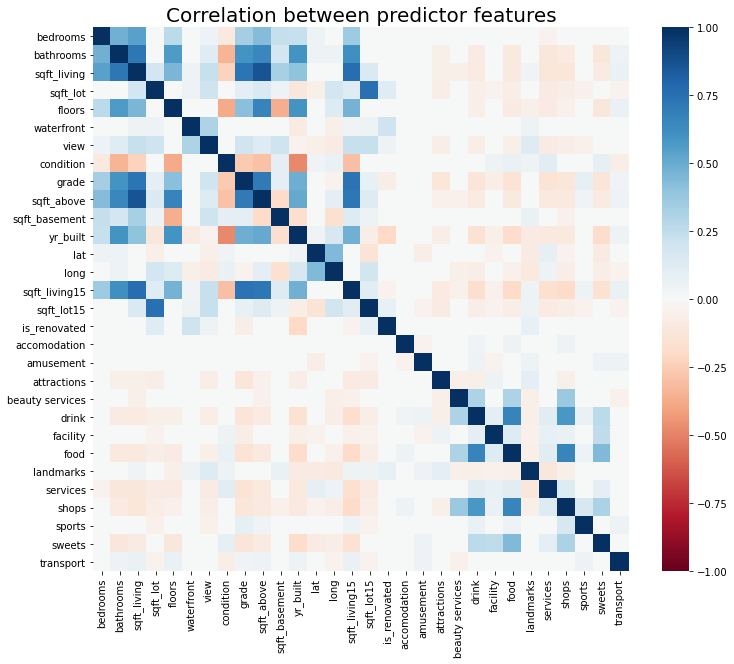

In [26]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(corr, 
        xticklabels = corr.columns,
        yticklabels = corr.columns,
        vmin = -1, vmax = 1,
        cmap = "RdBu",
        ax = ax)
ax.set_title('Correlation between predictor features', fontsize = 20)
plt.savefig('output_figures/cor.png')

## Search for highly correlated features

In [149]:
col_a = []
col_b = []
col_val = []

for i in range(corr.shape[0]):
    for j in range(corr.shape[0]):
        if i < j:
            if np.absolute(corr.iloc[i,j]) > 0.65:
                col_a.append(corr.columns.tolist()[i])
                col_b.append(corr.columns.tolist()[j])
                col_val.append(corr.iloc[i,j])

                # print(corr.columns.tolist()[i], corr.columns.tolist()[j], corr.iloc[i,j], sep = '  ')
                
dict0 = {'x': col_a, 'y': col_b, 'r_pearson': col_val}

corr0 = pd.DataFrame(dict0)
corr0.sort_values('r_pearson', ascending = False)
corr0

x              y  r_pearson
0     bathrooms    sqft_living       0.72
1   sqft_living          grade       0.73
2   sqft_living     sqft_above       0.86
3   sqft_living  sqft_living15       0.76
4      sqft_lot     sqft_lot15       0.75
5        floors     sqft_above       0.67
6         grade     sqft_above       0.71
7         grade  sqft_living15       0.74
8    sqft_above  sqft_living15       0.72
9         drink           food       0.67
10         food          shops       0.66

In [150]:
dict0 = {'appearances': col_a + col_b}
temp = pd.DataFrame(dict0)
del dict0
temp.appearances.value_counts()

sqft_living      4
sqft_above       4
grade            3
sqft_living15    3
food             2
sqft_lot         1
drink            1
shops            1
floors           1
bathrooms        1
sqft_lot15       1
Name: appearances, dtype: int64

### Conclusions
* `sqft_above` can be discarded, as it is highly correlated with five variables. After all, square `sqft_living = sqft_above + sqft_basement`, so `sqft_above` is extra information.
* `grade` can aslo be discarded, as it is a subjective value anyway.
* `sqft_living15` and `sqft_living15` will be the final features to be disparded, as they are highly correlated with their respective features. This means that the total house area is similar to the total house area of the 15 neighboring houses. The same applies for the lot area. 

In [151]:
df0.drop(['sqft_above', 'grade', 'sqft_living15', 'sqft_lot15'], axis = 1, inplace = True)

corr = df0.iloc[:,1:].corr().round(2)

col_a = []
col_b = []
col_val = []

for i in range(corr.shape[0]):
    for j in range(corr.shape[0]):
        if i < j:
            if np.absolute(corr.iloc[i,j]) > 0.65:
                col_a.append(corr.columns.tolist()[i])
                col_b.append(corr.columns.tolist()[j])
                col_val.append(corr.iloc[i,j])

                # print(corr.columns.tolist()[i], corr.columns.tolist()[j], corr.iloc[i,j], sep = '  ')
                
dict0 = {'x': col_a, 'y': col_b, 'r_pearson': col_val}

corr0 = pd.DataFrame(dict0)
corr0.sort_values('r_pearson', ascending = False)
corr0

x            y  r_pearson
0  bathrooms  sqft_living       0.72
1      drink         food       0.67
2       food        shops       0.66

We will not discard any further features. Despite the amount of bathroums and house area being correlated, these are two important features for houses, therefore we will keep them. 
We also observe that food venues are more when drink venues or shops are more.

In [157]:
# df0.to_csv('df_final.csv')
# print('saved!')

saved!


# Part 7: Modeling
___
* We will split the data set in train and test sets
* We will create various regression models to predict the house prices

## Read the dataset, get the feature and target

In [27]:
df0 = pd.read_csv('df_final.csv').iloc[:,1:]

x = df0.drop('price', axis = 1)
y = df0.price

print(df0.shape, x.shape, y.shape)

(2766, 27) (2766, 26) (2766,)


## Import modules

In [4]:
# Split data to Train and Test set 
from sklearn.model_selection import train_test_split

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model explainability
from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import permutation_importance

# Metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Create train and test sets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 692
number of training samples: 2074


## Create an evaluation report pandas data frame
We will keep here the model names and details, along with the corresponding scores

In [113]:
report = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Mean Squared Error (MSE)':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Mean Absolute Error (MAE)':[],
                           'R-squared (test)':[],
                           'R-squared (training)':[],
                           'CrossVal (4-Fold) Mean':[],
                           'CrossVal (4-Fold) SD':[]})

report.shape

(0, 9)

## Define a report function
Based on report data frame, we will get a report printed for each model

In [148]:
def report_print(i, df = report):
    print('#<' + '~'*55 + '>\n#')
    print('# ' + df.iloc[i,0] + ' - ' + df.iloc[i,1] )
    print('#\n#<' + '~'*55 + '>\n')
     
    for t in range(2,9): 
        print('{:<31}: {:<14}'.format(df.columns[t], str(df.iloc[i,t])))
    return

## Define a distribution function
This function will help us inspect the difference between the actual values and the predicted ones

In [86]:
def distribution_plot(y_real, y_predicted, fig_title, figure_size = (10,6)):
    
    plt.figure(figsize = figure_size)

    ax1 = sns.distplot(y_real, hist = False, color = "red", label = "Actual Value")
    sns.distplot(y_predicted, hist = False, color = "blue", label = "Predicted Values" , ax = ax1)
    
    ax1.set(ylim = (0, 0.000006))
    ax1.set(xlim = (-0.2*1000000, 1.6*1000000))

    plt.title(fig_title, fontsize = 18)
    plt.xlabel('Price', fontsize = 14)
    plt.ylabel('Proportion of Houses', fontsize = 14)

    #plt.show()
    fig_path = 'output_figures\\' + fig_title.replace(' ', '_').lower() + '.png'
    plt.savefig(fig_path   , dpi = 200)
    #plt.close()

## Define a permutation importance function

In [87]:
def df_perm(model, x, y, x_names):
    result = permutation_importance(model, x, y, random_state = 0)
    perms = pd.DataFrame(x_names, columns = ['feature'])
    perms['feature_importance'] = result.importances_mean.tolist()
    return perms

## Model 1: Linear regression

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Linear Regression - All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2530438603.6392
Root Mean Squared Error (RMSE) : 50303.4651    
Mean Absolute Error (MAE)      : 34409.7484    
R-squared (test)               : 0.7629        
R-squared (training)           : 0.7519        
CrossVal (4-Fold) Mean         : 0.7159        
CrossVal (4-Fold) SD           : 0.0           


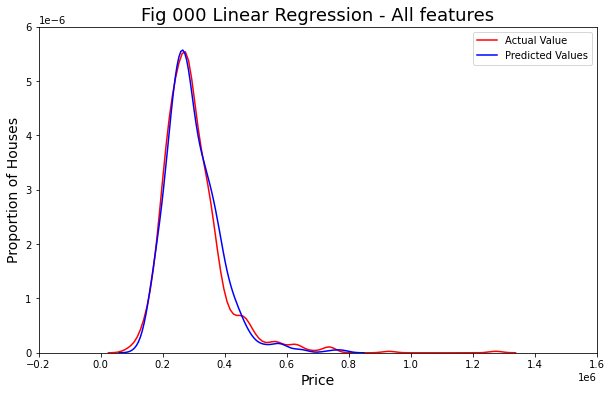

In [114]:
lm1 = LinearRegression()
lm1.fit(x_train, y_train)

y_pred = lm1.predict(x_test)

Rcross = cross_val_score(lm1, x, y, cv = 4).mean()

indx = 0

report.loc[indx] = ['Linear Regression',
                               'All features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm1.score(x_test, y_test), 4),
                               round(lm1.score(x_train, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

In [115]:
perms01 = df_perm(lm1, x_test, y_test, x.columns.tolist())
perms01.sort_values('feature_importance', ascending = False).head(15)

feature  feature_importance
2     sqft_living            1.128253
3        sqft_lot            0.082642
8   sqft_basement            0.033606
6            view            0.032784
9        yr_built            0.027629
0        bedrooms            0.015853
10            lat            0.015239
5      waterfront            0.007805
7       condition            0.006037
1       bathrooms            0.004664
4          floors            0.003993
12   is_renovated            0.003208
19           food            0.001977
24         sweets            0.000877
21       services            0.000844

In [90]:
lm1.intercept_

-11666227.868114222

In [116]:
perms01['coeficient'] = [round(x,4) for x in lm1.coef_.tolist()]
perms01.set_index('feature')
perms01.to_csv('output_models/001_linear_model.csv')

In [179]:
perms01.sort_values('feature_importance', ascending = False).head(15)

feature  feature_importance   coeficient
2     sqft_living            1.128253     111.5487
3        sqft_lot            0.082642       0.7479
8   sqft_basement            0.033606     -36.8534
6            view            0.032784   28801.7690
9        yr_built            0.027629     541.6819
0        bedrooms            0.015853  -10765.3669
10            lat            0.015239  220268.5420
5      waterfront            0.007805   99111.3753
7       condition            0.006037    9787.4028
1       bathrooms            0.004664    7747.3778
4          floors            0.003993   -9659.7730
12   is_renovated            0.003208   32812.6287
19           food            0.001977   -1148.7272
24         sweets            0.000877   -3361.8887
21       services            0.000844   -2173.1272

### A first inspection:
* The number of bedrooms has a negative impact of the price. The following figure shows that more bedrooms do not necessarily mean higher price. After all, the two features have weak correlation.
* Living area (sqft) is the most important feature. Each sqft unit increases the price by 111.54 price units. Such result is only logical, as we expect to pay more for more area.
* Lot and basement area are the next two important features. In general, the area of the house affects the price. It is noted that each basement unit decreases the price by 36 units. This might has to do with the fact that most houses do not have a basement.
* Latitude is more important than longitude for house pricing. As we proceed to northen houses (increase in latitude), the price increases.
* The most important features have to do with the house itself, not the nearest venues. Food, sweet and services venues are in the top 15 important features. But only drink venues have a positive impact on the price. In fact, most venue groups seem to have a negative impact on the price. More on that in the report.

In [117]:
temp, _ = stats.pearsonr(df0.bedrooms, df0.price)
print('Correlation between bedrooms and price is {} (p={})'.format(round(temp,4), round(_,4)))

print('We have {} out of {} houses with no basement (basement area = 0)'.format(df0.sqft_basement[df0.sqft_basement == 0].shape[0], 
                                                                                df0.sqft_basement.shape[0])) 

Correlation between bedrooms and price is 0.3338 (p=0.0)
We have 2035 out of 2766 houses with no basement (basement area = 0)


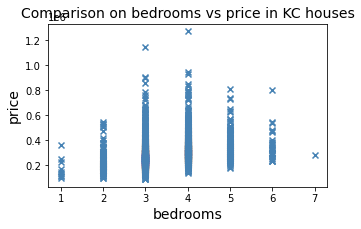

In [118]:
plt.figure(figsize = (5,3))
plt.scatter(x = 'bedrooms', y = 'price', data = df0, color = 'steelblue', marker = 'x')
plt.xlabel('bedrooms', fontsize = 14)
plt.ylabel('price', fontsize = 14)
plt.title('Comparison on bedrooms vs price in KC houses', fontsize = 14)
plt.show()

## We will try two new linear models, with the 10 and 15 most important features respectively

In [121]:
temp = perms01.sort_values(by = ['feature_importance'], ascending = False).reset_index()['feature']
lis115 = temp.tolist()[0:15]
lis110 = temp.tolist()[0:10]
print(lis115, '\n', lis110)

['sqft_living', 'sqft_lot', 'sqft_basement', 'view', 'yr_built', 'bedrooms', 'lat', 'waterfront', 'condition', 'bathrooms', 'floors', 'is_renovated', 'food', 'sweets', 'services'] 
 ['sqft_living', 'sqft_lot', 'sqft_basement', 'view', 'yr_built', 'bedrooms', 'lat', 'waterfront', 'condition', 'bathrooms']


### Top 15 features

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Linear Regression - Top 15 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2518221237.2655
Root Mean Squared Error (RMSE) : 50181.8816    
Mean Absolute Error (MAE)      : 34180.5789    
R-squared (test)               : 0.764         
R-squared (training)           : 0.7498        
CrossVal (4-Fold) Mean         : 0.7154        
CrossVal (4-Fold) SD           : 0.0           


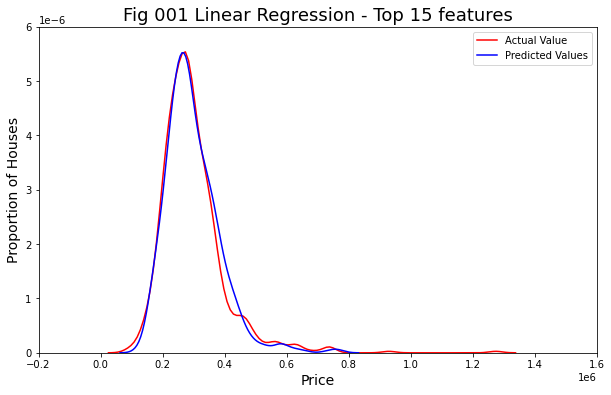

In [122]:
lm1_15 = LinearRegression()
lm1_15.fit(x_train[lis115], y_train)

y_pred = lm1_15.predict(x_test[lis115])

Rcross = cross_val_score(lm1_15, x[lis115], y, cv = 4).mean()

indx = 1

report.loc[indx] = ['Linear Regression',
                               'Top 15 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm1_15.score(x_test[lis115], y_test), 4),
                               round(lm1_15.score(x_train[lis115], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

### Top 10 features

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Linear Regression - Top 10 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2581897035.9286
Root Mean Squared Error (RMSE) : 50812.3709    
Mean Absolute Error (MAE)      : 34575.3377    
R-squared (test)               : 0.7581        
R-squared (training)           : 0.7468        
CrossVal (4-Fold) Mean         : 0.7114        
CrossVal (4-Fold) SD           : 0.0           


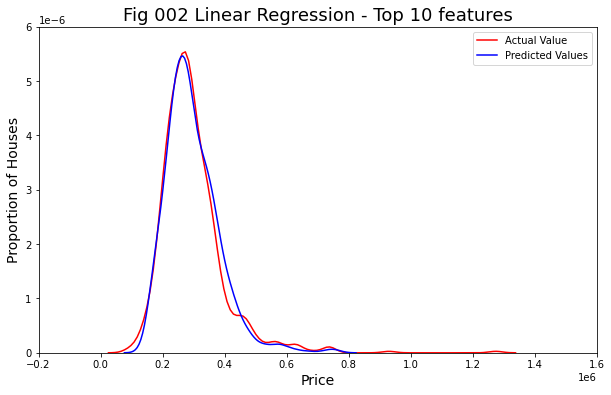

In [123]:
lm1_10 = LinearRegression()
lm1_10.fit(x_train[lis110], y_train)

y_pred = lm1_10.predict(x_test[lis110])

Rcross = cross_val_score(lm1_10, x[lis110], y, cv = 4).mean()

indx = 2

report.loc[indx] = ['Linear Regression',
                               'Top 10 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm1_10.score(x_test[lis110], y_test), 4),
                               round(lm1_10.score(x_train[lis110], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

### So far, the linear model with the top 15 features seems to have the best metrics

In [124]:
report

Model          Details  Mean Squared Error (MSE)  \
0  Linear Regression     All features              2.530439e+09   
1  Linear Regression  Top 15 features              2.518221e+09   
2  Linear Regression  Top 10 features              2.581897e+09   

   Root Mean Squared Error (RMSE)  Mean Absolute Error (MAE)  \
0                      50303.4651                 34409.7484   
1                      50181.8816                 34180.5789   
2                      50812.3709                 34575.3377   

   R-squared (test)  R-squared (training)  CrossVal (4-Fold) Mean  \
0            0.7629                0.7519                  0.7159   
1            0.7640                0.7498                  0.7154   
2            0.7581                0.7468                  0.7114   

   CrossVal (4-Fold) SD  
0                   0.0  
1                   0.0  
2                   0.0

## Model 2: Polynomial model (degree = 2)

In [125]:
pr = PolynomialFeatures(degree = 2, include_bias = False)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
x_pr = pr.fit_transform(x)

pr_names = pr.get_feature_names(input_features = x_train.columns.tolist())
len(pr_names)

377

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Polynomial Reg (d=2) - All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2921933425.9805
Root Mean Squared Error (RMSE) : 54054.9112    
Mean Absolute Error (MAE)      : 36326.2647    
R-squared (test)               : 0.7262        
R-squared (training)           : 0.859         
CrossVal (4-Fold) Mean         : 0.5545        
CrossVal (4-Fold) SD           : 0.0           


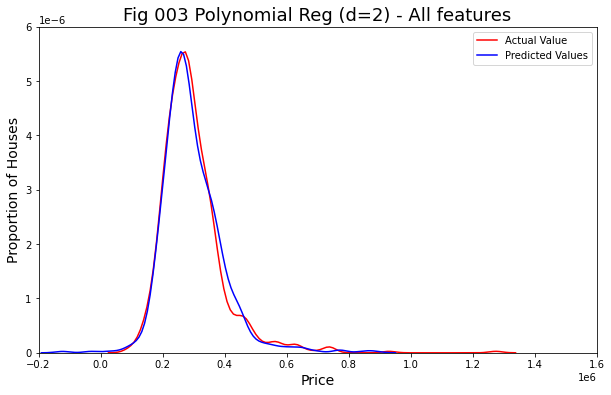

In [126]:
lm2 = LinearRegression()
lm2.fit(x_train_pr, y_train)

y_pred = lm2.predict(x_test_pr)

Rcross = cross_val_score(lm2, x_pr, y, cv = 4).mean()

indx = 3

report.loc[indx] = ['Polynomial Reg (d=2)',
                               'All features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm2.score(x_test_pr, y_test), 4),
                               round(lm2.score(x_train_pr, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

In [127]:
perms02 = df_perm(lm2, x_test_pr, y_test, pr_names)
perms02.sort_values('feature_importance', ascending = False).head(15)

feature  feature_importance
6                view       107492.637570
21           services        44007.752119
10                lat        38856.708280
172         view long        28939.161795
11               long        25792.071378
171          view lat        21275.314618
14          amusement        16143.243595
242          lat long        15611.083071
86   sqft_living long        12937.426630
267     long services        11678.849076
2         sqft_living         9878.972507
252      lat services         8256.190447
22              shops         7933.466505
260    long amusement         7810.014732
25          transport         7670.965022

In [129]:
perms02['coeficient'] = [round(x,4) for x in lm2.coef_.tolist()]
perms02.set_index('feature')
perms02.to_csv('output_models/002_polynomial_linear_model.csv')

### We will perform polynomial regression fewer features

In [130]:
temp = perms.sort_values(by = ['feature_importance'], ascending = False).reset_index()['feature']
lis21 = temp.tolist()[0:350]
lis22 = temp.tolist()[0:300]
print(len(lis1), len(lis2))

350 300


### Top 350 features

In [132]:
lm2_01 = LinearRegression()
lm2_01.fit(x_train_pr[:, [pr_names.index(x) for x in lis21]], y_train)

y_pred = lm2_01.predict(x_test_pr[:, [pr_names.index(x) for x in lis21]])

Rcross = cross_val_score(lm2_01, x_pr[:, [pr_names.index(x) for x in lis21]], y, cv = 4).mean()

indx = 4

report.loc[indx] = ['Polynomial Reg (d=2)',
                               'Top 350 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm2_01.score(x_test_pr[:, [pr_names.index(x) for x in lis21]], y_test), 4),
                               round(lm2_01.score(x_train_pr[:, [pr_names.index(x) for x in lis21]], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Polynomial Reg (d=2) - Top 350 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2933111568.9326
Root Mean Squared Error (RMSE) : 54158.2087    
Mean Absolute Error (MAE)      : 35644.8392    
R-squared (test)               : 0.7251        
R-squared (training)           : 0.8498        
CrossVal (4-Fold) Mean         : 0.6259        
CrossVal (4-Fold) SD           : 0.0           


### Top 300 features

In [133]:
lm2_02 = LinearRegression()
lm2_02.fit(x_train_pr[:, [pr_names.index(x) for x in lis22]], y_train)

y_pred = lm2_02.predict(x_test_pr[:, [pr_names.index(x) for x in lis22]])

Rcross = cross_val_score(lm2_02, x_pr[:, [pr_names.index(x) for x in lis22]], y, cv = 4).mean()

indx = 5

report.loc[indx] = ['Polynomial Reg (d=2)',
                               'Top 300 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm2_02.score(x_test_pr[:, [pr_names.index(x) for x in lis22]], y_test), 4),
                               round(lm2_02.score(x_train_pr[:, [pr_names.index(x) for x in lis22]], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Polynomial Reg (d=2) - Top 300 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 9159468139.7392
Root Mean Squared Error (RMSE) : 95705.1103    
Mean Absolute Error (MAE)      : 38884.7937    
R-squared (test)               : 0.1417        
R-squared (training)           : 0.8476        
CrossVal (4-Fold) Mean         : 0.6495        
CrossVal (4-Fold) SD           : 0.0           


### Top 15 features from model 1

In [134]:
pr = PolynomialFeatures(degree = 2, include_bias = False)
x_train_pr = pr.fit_transform(x_train[lis115])
x_test_pr = pr.fit_transform(x_test[lis115])
x_pr = pr.fit_transform(x[lis115])

pr_names = pr.get_feature_names(input_features = x_train[lis115].columns.tolist())
len(pr_names)

135

In [135]:
lm2_03 = LinearRegression()
lm2_03.fit(x_train_pr, y_train)

y_pred = lm2_03.predict(x_test_pr)

Rcross = cross_val_score(lm2_03, x_pr, y, cv = 4).mean()

indx = 6

report.loc[indx] = ['Polynomial Reg (d=2)',
                               'Top 15 features from model 1',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(lm2_03.score(x_test_pr, y_test), 4),
                               round(lm2_03.score(x_train_pr, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Polynomial Reg (d=2) - Top 15 features from model 1
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2656135941.9216
Root Mean Squared Error (RMSE) : 51537.7138    
Mean Absolute Error (MAE)      : 33437.2147    
R-squared (test)               : 0.7511        
R-squared (training)           : 0.8249        
CrossVal (4-Fold) Mean         : 0.706         
CrossVal (4-Fold) SD           : 0.0           


## Ridge model

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Ridge Linear Regression - a = 0.1, All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2532447128.3806
Root Mean Squared Error (RMSE) : 50323.4252    
Mean Absolute Error (MAE)      : 34407.0399    
R-squared (test)               : 0.7627        
R-squared (training)           : 0.7519        
CrossVal (4-Fold) Mean         : 0.721         
CrossVal (4-Fold) SD           : 0.0558        


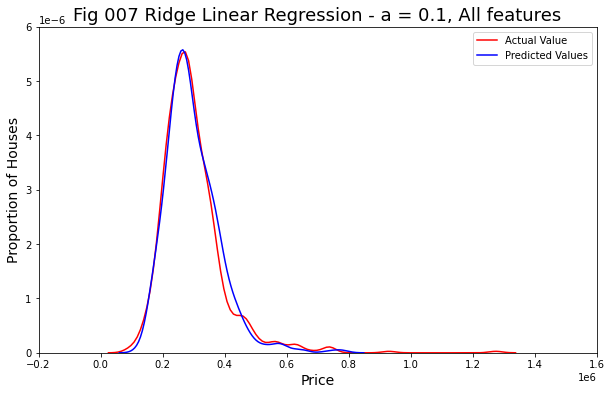

In [136]:
rdg1 = Ridge(alpha = 0.1)
rdg1.fit(x_train, y_train)

y_pred = rdg1.predict(x_test)

Rcross = cross_val_score(rdg1, x, y, cv = 4)

indx = 7

report.loc[indx] = ['Ridge Linear Regression',
                               'a = 0.1, All features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(rdg1.score(x_test, y_test), 4),
                               round(rdg1.score(x_train, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

In [140]:
perms03 = df_perm(rdg1, x_test, y_test, x_test.columns.tolist())
perms03.sort_values('feature_importance', ascending = False).head(15)

feature  feature_importance
2     sqft_living            1.127705
3        sqft_lot            0.082174
8   sqft_basement            0.033422
6            view            0.032973
9        yr_built            0.027413
0        bedrooms            0.015848
10            lat            0.014545
5      waterfront            0.007554
7       condition            0.005993
1       bathrooms            0.004738
4          floors            0.003976
12   is_renovated            0.003184
19           food            0.001982
24         sweets            0.000897
21       services            0.000831

In [141]:
perms03['coeficient'] = [round(x,4) for x in rdg1.coef_.tolist()]
perms03.set_index('feature')
perms03.to_csv('output_models/003_ridge_linear_model.csv')

In [142]:
temp = perms03.sort_values(by = ['feature_importance'], ascending = False).reset_index()['feature']
lis315 = temp.tolist()[0:15]
lis310 = temp.tolist()[0:10]
print(lis315, '\n', lis310)

['sqft_living', 'sqft_lot', 'sqft_basement', 'view', 'yr_built', 'bedrooms', 'lat', 'waterfront', 'condition', 'bathrooms', 'floors', 'is_renovated', 'food', 'sweets', 'services'] 
 ['sqft_living', 'sqft_lot', 'sqft_basement', 'view', 'yr_built', 'bedrooms', 'lat', 'waterfront', 'condition', 'bathrooms']


### Top 15 features


#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Ridge Linear Regression - a = 0.1, Top 15 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2519672682.2707
Root Mean Squared Error (RMSE) : 50196.3413    
Mean Absolute Error (MAE)      : 34176.7613    
R-squared (test)               : 0.7639        
R-squared (training)           : 0.7498        
CrossVal (4-Fold) Mean         : 0.7205        
CrossVal (4-Fold) SD           : 0.0           


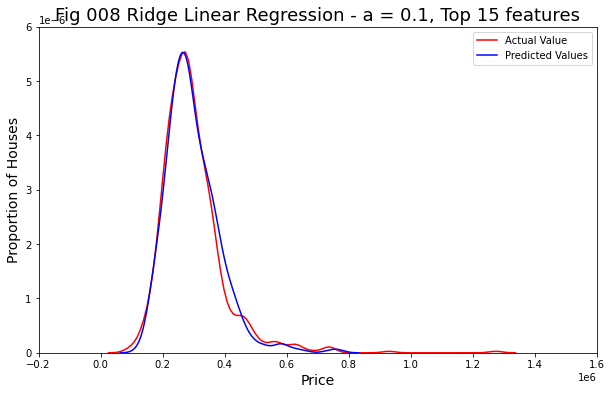

In [150]:
rdg15 = Ridge(alpha = 0.1)
rdg15.fit(x_train[lis315], y_train)

y_pred = rdg15.predict(x_test[lis315])

Rcross = cross_val_score(rdg15, x[lis315], y, cv = 4).mean()

indx = 8

report.loc[indx] = ['Ridge Linear Regression',
                               'a = 0.1, Top 15 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(rdg15.score(x_test[lis315], y_test), 4),
                               round(rdg15.score(x_train[lis315], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

In [ ]:
### Top 10 features

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Ridge Linear Regression - a = 0.1, Top 10 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2583373976.8061
Root Mean Squared Error (RMSE) : 50826.9021    
Mean Absolute Error (MAE)      : 34571.7113    
R-squared (test)               : 0.7579        
R-squared (training)           : 0.7468        
CrossVal (4-Fold) Mean         : 0.7167        
CrossVal (4-Fold) SD           : 0.0           


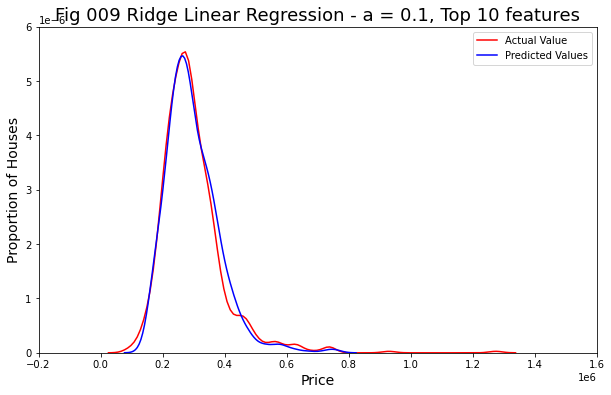

In [152]:
rdg10 = Ridge(alpha = 0.1)
rdg10.fit(x_train[lis310], y_train)

y_pred = rdg10.predict(x_test[lis310])

Rcross = cross_val_score(rdg10, x[lis310], y, cv = 4).mean()

indx = 9

report.loc[indx] = ['Ridge Linear Regression',
                               'a = 0.1, Top 10 features',
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(rdg10.score(x_test[lis310], y_test), 4),
                               round(rdg10.score(x_train[lis310], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(indx)

indx0 = 'Fig {:03d} '.format(indx)

distribution_plot(y_test, y_pred, indx0 + report.iloc[indx,0] + ' - ' + report.iloc[indx,1])

In [153]:
report

Model                       Details  \
0        Linear Regression                  All features   
1        Linear Regression               Top 15 features   
2        Linear Regression               Top 10 features   
3     Polynomial Reg (d=2)                  All features   
4     Polynomial Reg (d=2)              Top 350 features   
5     Polynomial Reg (d=2)              Top 300 features   
6     Polynomial Reg (d=2)  Top 15 features from model 1   
7  Ridge Linear Regression         a = 0.1, All features   
8  Ridge Linear Regression      a = 0.1, Top 15 features   
9  Ridge Linear Regression      a = 0.1, Top 10 features   

   Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  \
0              2.530439e+09                      50303.4651   
1              2.518221e+09                      50181.8816   
2              2.581897e+09                      50812.3709   
3              2.921933e+09                      54054.9112   
4              2.530439e+09                      50303.4651   
5              2.530439e+09                      50303.4651   
6              2.656136e+09                      51537.7138   
7              2.532447e+09                      50323.4252   
8              2.519673e+09                      50196.3413   
9              2.583374e+09                      50826.9021   

   Mean Absolute Error (MAE)  R-squared (test)  R-squared (training)  \
0                 34409.7484            0.7629                0.7519   
1                 34180.5789            0.7640                0.7498   
2                 34575.3377            0.7581                0.7468   
3                 36326.2647            0.7262                0.8590   
4                 34409.7484            0.7629                0.7519   
5                 34409.7484            0.7629                0.7519   
6                 33437.2147            0.7511                0.8249   
7                 34407.0399            0.7627                0.7519   
8                 34176.7613            0.7639                0.7498   
9                 34571.7113            0.7579                0.7468   

   CrossVal (4-Fold) Mean  CrossVal (4-Fold) SD  
0                  0.7159                0.0000  
1                  0.7154                0.0000  
2                  0.7114                0.0000  
3                  0.5545                0.0000  
4                  0.7159                0.0000  
5                  0.7159                0.0000  
6                  0.7060                0.0000  
7                  0.7210                0.0558  
8                  0.7205                0.0000  
9                  0.7167                0.0000

In [138]:
# report.to_csv('model_report.csv')
# print('saved!')

## Random Forest Regression

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Random Forest - 50 estimators, All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2404170361.2331
Root Mean Squared Error (RMSE) : 49032.34      
Mean Absolute Error (MAE)      : 32053.3813    
R-squared (test)               : 0.7747        
R-squared (training)           : 0.959         
CrossVal (4-Fold) Mean         : 0.732         
CrossVal (4-Fold) SD           : 0.0293        
Step 1 from 6 done!
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# Random Forest - 100 estimators, All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2383039415.9582
Root Mean Squared Error (RMSE) : 48816.3847    
Mean Absolute Error (MAE)      : 31896.0149    
R-squared (test)               : 0.7767        
R-squared (training)           : 0.9596        
CrossVal (4-Fold) Mean         : 0.7397        
CrossVal (4-Fol

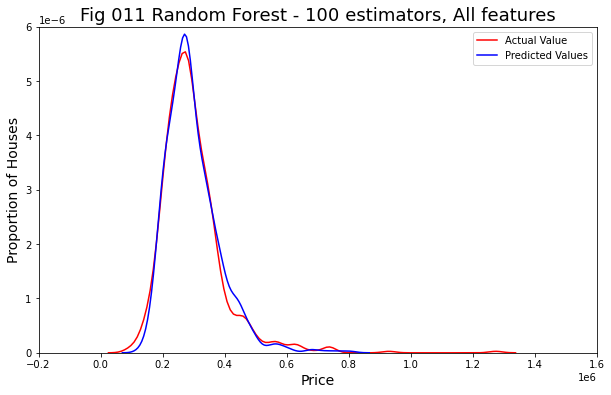

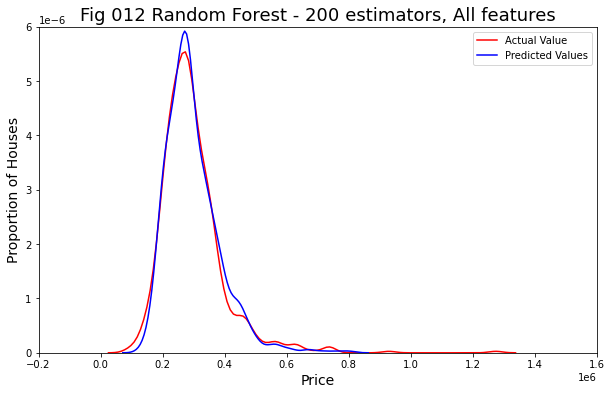

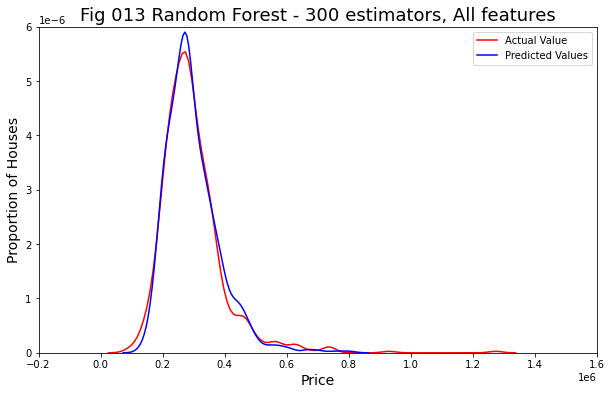

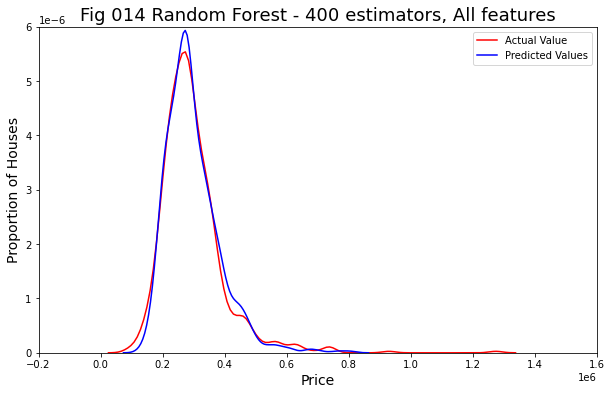

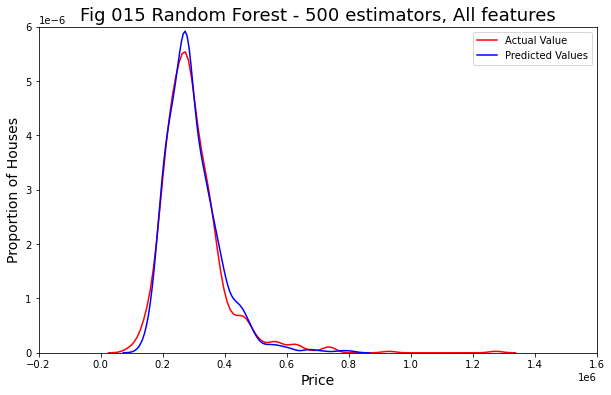

In [154]:
n_est = [50, 100, 200, 300, 400, 500]
placeholder = [t for t in range(10,16)]

for i in range(6):
    rfm = RandomForestRegressor(random_state = 0, n_estimators = n_est[i])
    rfm.fit(x_train, y_train)

    y_pred = rfm.predict(x_test)

    Rcross = cross_val_score(rfm, x, y, cv = 4)

    report.loc[placeholder[i]] = ['Random Forest',
                               '{} estimators, All features'.format(n_est[i]),
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(rfm.score(x_test, y_test), 4),
                               round(rfm.score(x_train, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]
    report_print(placeholder[i])

    indx0 = 'Fig {:03d} '.format(placeholder[i])

    distribution_plot(y_test, y_pred, indx0 + report.iloc[placeholder[i],0] + ' - ' + report.iloc[placeholder[i],1])
    print('Step {} from 6 done!'.format(str(i+1)))

In [156]:
report.tail(6)

Model                       Details  Mean Squared Error (MSE)  \
10  Random Forest   50 estimators, All features              2.404170e+09   
11  Random Forest  100 estimators, All features              2.383039e+09   
12  Random Forest  200 estimators, All features              2.367943e+09   
13  Random Forest  300 estimators, All features              2.351699e+09   
14  Random Forest  400 estimators, All features              2.343925e+09   
15  Random Forest  500 estimators, All features              2.334396e+09   

    Root Mean Squared Error (RMSE)  Mean Absolute Error (MAE)  \
10                      49032.3400                 32053.3813   
11                      48816.3847                 31896.0149   
12                      48661.5101                 31676.3119   
13                      48494.3229                 31503.6009   
14                      48414.1023                 31516.2945   
15                      48315.5904                 31484.8109   

    R-squared (test)  R-squared (training)  CrossVal (4-Fold) Mean  \
10            0.7747                0.9590                  0.7320   
11            0.7767                0.9596                  0.7397   
12            0.7781                0.9606                  0.7408   
13            0.7796                0.9611                  0.7392   
14            0.7804                0.9613                  0.7386   
15            0.7812                0.9614                  0.7384   

    CrossVal (4-Fold) SD  
10                0.0293  
11                0.0324  
12                0.0316  
13                0.0321  
14                0.0311  
15                0.0314

## XGBoost Regression

[08:38:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# XGBoost Regression - 300 estimators, l. rate 0.1, All features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2019218535.5905
Root Mean Squared Error (RMSE) : 44935.7156    
Mean Absolute Error (MAE)      : 30271.5383    
R-squared (test)               : 0.8108        
R-squared (training)           : 0.9137

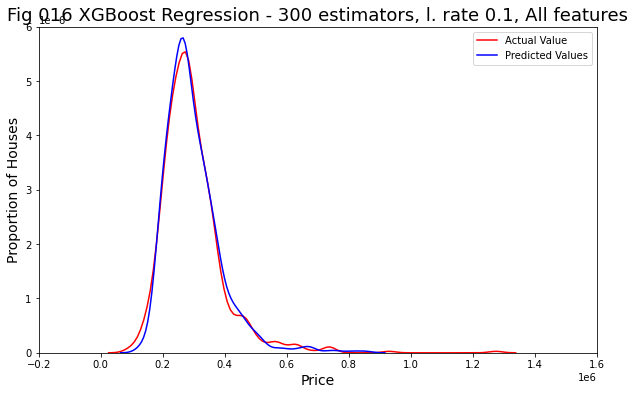

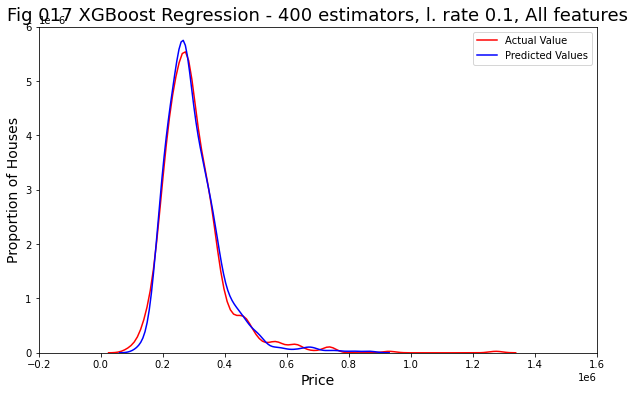

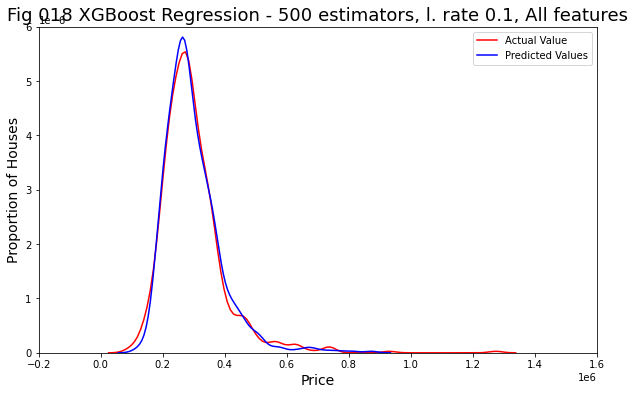

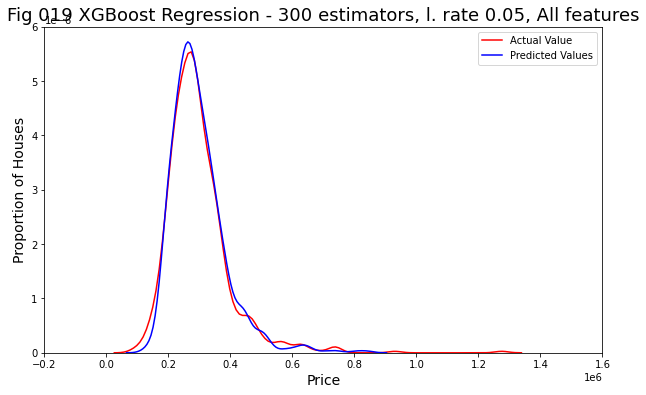

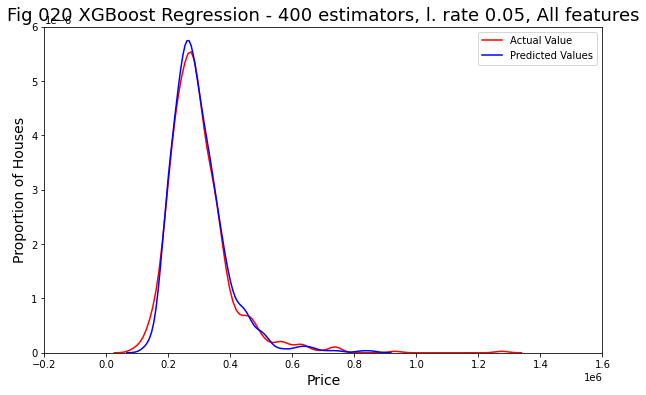

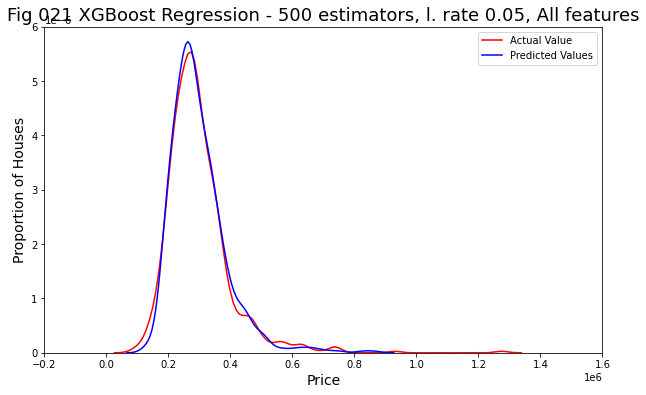

In [167]:
n_est = [300, 400, 500]*2
l_rate = [0.1]*3+[0.05]*3
placeholder = [t for t in range(16,22)]

for i in range(6):
    xgbr = XGBRegressor(random_state = 0, n_estimators = n_est[i], learning_rate = l_rate[i])
    xgbr.fit(x_train, y_train)

    y_pred = xgbr.predict(x_test)

    Rcross = cross_val_score(xgbr, x, y, cv = 4)

    report.loc[placeholder[i]] = ['XGBoost Regression',
                               '{} estimators, l. rate {}, All features'.format(n_est[i], l_rate[i]),
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(xgbr.score(x_test, y_test), 4),
                               round(xgbr.score(x_train, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]
    report_print(placeholder[i])

    indx0 = 'Fig {:03d} '.format(placeholder[i])

    distribution_plot(y_test, y_pred, indx0 + report.iloc[placeholder[i],0] + ' - ' + report.iloc[placeholder[i],1])
    print('Step {} from 6 done!'.format(str(i+1)))

### Random Forest and XGBoost perform better
They can capture the non-linearities. Price has low pearson correlation with the majority of the features, meaning no good linear relationship.

In [183]:
df0.corr().iloc[1:, 0].abs().describe()

count    26.000000
mean      0.186313
std       0.191727
min       0.010667
25%       0.056943
50%       0.121039
75%       0.293108
max       0.801526
Name: price, dtype: float64

### We will try one last xgboost model
We will keep the number of estimators and learning rate of the best performing one. Just for reference, we re-run it with the parameters and its index in report data frame.

In [169]:
xgbr = XGBRegressor(random_state = 0, n_estimators = 500, learning_rate = 0.05)
xgbr.fit(x_train, y_train)

y_pred = xgbr.predict(x_test)

Rcross = cross_val_score(xgbr, x, y, cv = 4)

report.loc[21] = ['XGBoost Regression',
                               '{} estimators, learning rate {}, All features'.format(500, 0.05),
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(xgbr.score(x_test, y_test), 4),
                               round(xgbr.score(x_train, y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

[08:39:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [170]:
report.tail(6)

Model                                           Details  \
16  XGBoost Regression         300 estimators, l. rate 0.1, All features   
17  XGBoost Regression         400 estimators, l. rate 0.1, All features   
18  XGBoost Regression         500 estimators, l. rate 0.1, All features   
19  XGBoost Regression        300 estimators, l. rate 0.05, All features   
20  XGBoost Regression        400 estimators, l. rate 0.05, All features   
21  XGBoost Regression  500 estimators, learning rate 0.05, All features   

    Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  \
16              2.019219e+09                      44935.7156   
17              2.008734e+09                      44818.8982   
18              2.006261e+09                      44791.3097   
19              2.030168e+09                      45057.3886   
20              1.993718e+09                      44651.0750   
21              1.987708e+09                      44583.7157   

    Mean Absolute Error (MAE)  R-squared (test)  R-squared (training)  \
16                 30271.5383            0.8108                0.9137   
17                 30322.5732            0.8118                0.9268   
18                 30332.7105            0.8120                0.9352   
19                 30526.5902            0.8098                0.8809   
20                 30314.8434            0.8132                0.8933   
21                 30240.5342            0.8137                0.9035   

    CrossVal (4-Fold) Mean  CrossVal (4-Fold) SD  
16                  0.7356                0.0517  
17                  0.7349                0.0513  
18                  0.7328                0.0510  
19                  0.7337                0.0480  
20                  0.7352                0.0502  
21                  0.7354                0.0524

With some trial and error, we obtained that the top 21 of 26 features improve the MAE and the Cross Validation scores.  
We will keep this model for reference.

In [171]:
perms04 = df_perm(xgbr, x_test, y_test, x_test.columns.tolist())
perms04.sort_values('feature_importance', ascending = False).head(15)

feature  feature_importance
2     sqft_living            0.821846
3        sqft_lot            0.193239
9        yr_built            0.091009
10            lat            0.048064
6            view            0.027879
11           long            0.019637
1       bathrooms            0.016348
8   sqft_basement            0.014082
7       condition            0.008153
0        bedrooms            0.006737
22          shops            0.002952
20      landmarks            0.002337
12   is_renovated            0.002244
4          floors            0.002196
5      waterfront            0.000472

In [172]:
perms04.set_index('feature')
perms04.to_csv('output_models/004_xgboost.csv')

[08:39:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
#
# XGBoost Regression - 500 estimators, l. rate 0.05, Top 21 features
#
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>

Mean Squared Error (MSE)       : 2018601119.5083
Root Mean Squared Error (RMSE) : 44928.8451    
Mean Absolute Error (MAE)      : 30238.2901    
R-squared (test)               : 0.8108        
R-squared (training)           : 0.

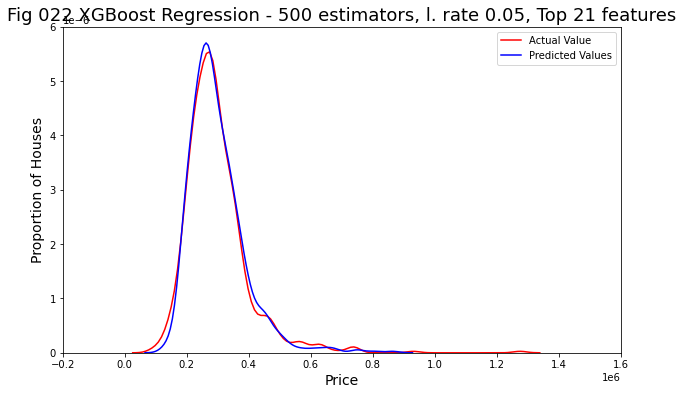

In [173]:
# Select the top features
top_no = 21
lis_xgb = perms04.sort_values(by = ['feature_importance'], ascending = False).feature.tolist()[0:top_no]

# Run the model for them
xgbr0 = XGBRegressor(random_state = 0, n_estimators = 500, learning_rate = 0.05)
xgbr0.fit(x_train[lis_xgb], y_train)

y_pred = xgbr0.predict(x_test[lis_xgb])

Rcross = cross_val_score(xgbr0, x[lis_xgb], y, cv = 4)

report.loc[22] = ['XGBoost Regression',
                               '{} estimators, l. rate {}, Top {} features'.format(500, 0.05, top_no),
                               round(mean_squared_error(y_pred, y_test), 4),
                               round(np.sqrt(mean_squared_error(y_pred, y_test)) ,4),
                               round(mean_absolute_error(y_pred, y_test), 4),
                               round(xgbr0.score(x_test[lis_xgb], y_test), 4),
                               round(xgbr0.score(x_train[lis_xgb], y_train), 4),
                               round(Rcross.mean(), 4),
                               round(Rcross.std(), 4)]

report_print(22)

indx0 = 'Fig {:03d} '.format(22)

distribution_plot(y_test, y_pred, indx0 + report.iloc[22,0] + ' - ' + report.iloc[22,1])

In [180]:
report

Model                                           Details  \
0         Linear Regression                                      All features   
1         Linear Regression                                   Top 15 features   
2         Linear Regression                                   Top 10 features   
3      Polynomial Reg (d=2)                                      All features   
4      Polynomial Reg (d=2)                                  Top 350 features   
5      Polynomial Reg (d=2)                                  Top 300 features   
6      Polynomial Reg (d=2)                      Top 15 features from model 1   
7   Ridge Linear Regression                             a = 0.1, All features   
8   Ridge Linear Regression                          a = 0.1, Top 15 features   
9   Ridge Linear Regression                          a = 0.1, Top 10 features   
10            Random Forest                       50 estimators, All features   
11            Random Forest                      100 estimators, All features   
12            Random Forest                      200 estimators, All features   
13            Random Forest                      300 estimators, All features   
14            Random Forest                      400 estimators, All features   
15            Random Forest                      500 estimators, All features   
16       XGBoost Regression         300 estimators, l. rate 0.1, All features   
17       XGBoost Regression         400 estimators, l. rate 0.1, All features   
18       XGBoost Regression         500 estimators, l. rate 0.1, All features   
19       XGBoost Regression        300 estimators, l. rate 0.05, All features   
20       XGBoost Regression        400 estimators, l. rate 0.05, All features   
21       XGBoost Regression  500 estimators, learning rate 0.05, All features   
22       XGBoost Regression     500 estimators, l. rate 0.05, Top 21 features   

    Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  \
0               2.530439e+09                      50303.4651   
1               2.518221e+09                      50181.8816   
2               2.581897e+09                      50812.3709   
3               2.921933e+09                      54054.9112   
4               2.530439e+09                      50303.4651   
5               2.530439e+09                      50303.4651   
6               2.656136e+09                      51537.7138   
7               2.532447e+09                      50323.4252   
8               2.519673e+09                      50196.3413   
9               2.583374e+09                      50826.9021   
10              2.404170e+09                      49032.3400   
11              2.383039e+09                      48816.3847   
12              2.367943e+09                      48661.5101   
13              2.351699e+09                      48494.3229   
14              2.343925e+09                      48414.1023   
15              2.334396e+09                      48315.5904   
16              2.019219e+09                      44935.7156   
17              2.008734e+09                      44818.8982   
18              2.006261e+09                      44791.3097   
19              2.030168e+09                      45057.3886   
20              1.993718e+09                      44651.0750   
21              1.987708e+09                      44583.7157   
22              2.018601e+09                      44928.8451   

    Mean Absolute Error (MAE)  R-squared (test)  R-squared (training)  \
0                  34409.7484            0.7629                0.7519   
1                  34180.5789            0.7640                0.7498   
2                  34575.3377            0.7581                0.7468   
3                  36326.2647            0.7262                0.8590   
4                  34409.7484            0.7629                0.7519   
5                  34409.7484            0.7629                0.7519   
6                  33437.2147

In [177]:
#report.to_csv('output_models/model_report.csv')
#print('saved!')

saved!


### An additional figure for the report!

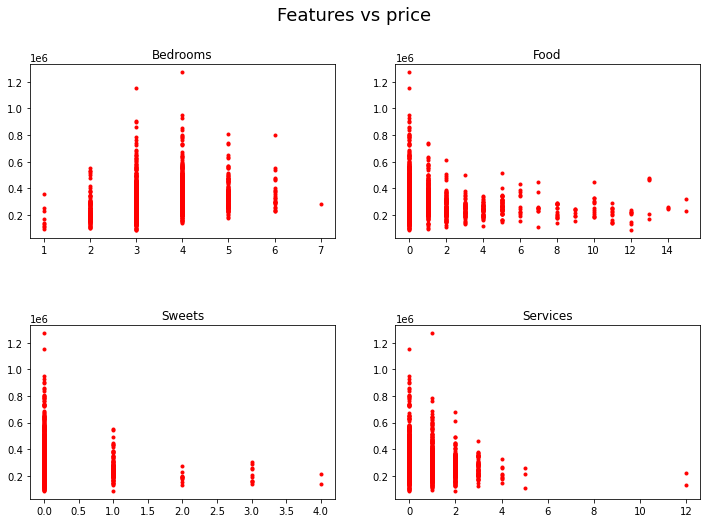

In [250]:
fig, axs = plt.subplots(2, 2,figsize=(12,8), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
(ax1, ax2), (ax3, ax4) = axs

fig.suptitle('Features vs price', fontsize = 18)

ax1.plot(df0.bedrooms, df0.price, '.', color = 'red')
ax2.plot(df0.food, df0.price, '.', color = 'red')
ax3.plot(df0.sweets, df0.price, '.', color = 'red')
ax4.plot(df0.services, df0.price, '.', color = 'red')

ax1.set_title('Bedrooms')
ax2.set_title('Food')
ax3.set_title('Sweets')
ax4.set_title('Services')

plt.savefig('output_figures/features_vs_price.png'   , dpi = 200)


# Thank you!